#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# pipe's mass is different from vessel's mass

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
node_N = 4

In [11]:
mi = [mp for i in range(node_N)] 

In [12]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # mass of the vessel, [kg] !!!!!!!!!!!!!!!!!! Solitaire type vessel 

In [13]:
vessel_mass=mn/L # mass over length of vessel

In [14]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [15]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [16]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [17]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [18]:
Irho+=vessel_inertia

In [19]:
vessel_inertia_coef = vessel_inertia/np.max(diag_Irho)

In [20]:
vessel_inertia_coef

4839473437.5

In [21]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [22]:
diag_DT = 1.5*np.array([1, 1, 1]) 
# diag_DT = 1.5e15*np.array([1, 1, 1]) # [N/m]  , p.99 in [1] !!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [23]:
DT=np.diag(diag_DT) # (35) in [2]

In [24]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [25]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [26]:
CT=np.diag(diag_CT)

In [27]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [28]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [29]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [30]:
rng = np.random.default_rng()

In [31]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [33]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[-0.05208686, -0.83043275, -0.55467865],
       [ 0.9160666 ,  0.18142448, -0.35764107],
       [ 0.39762915, -0.52675098,  0.75128188]])

In [34]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002565


In [35]:
Ret

array([[[-0.05208686, -0.83043275, -0.55467865],
        [ 0.9160666 ,  0.18142448, -0.35764107],
        [ 0.39762915, -0.52675098,  0.75128188]],

       [[ 0.73670999,  0.01092025,  0.67612065],
        [ 0.12965426,  0.9790372 , -0.15708575],
        [-0.66366269,  0.20338857,  0.71985063]],

       [[-0.9165569 ,  0.39955404, -0.01673369],
        [ 0.07497092,  0.13057605, -0.98859964],
        [-0.39281397, -0.90736237, -0.14963531]],

       [[-0.20664633,  0.86203256,  0.46281439],
        [ 0.29032388, -0.39769608,  0.87037341],
        [ 0.93434969,  0.31422555, -0.1680862 ]]])

In [36]:
Ret.shape

(4, 3, 3)

In [37]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [38]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [39]:
np.abs(dx)*dx

array([-0.83777779,  2.34728528,  6.09185614, -0.00856191])

In [40]:
C1(dx,dy,dz,Ret)

array([[ 0.84195269,  2.05426329,  5.37703392,  5.13651419],
       [ 2.17805125,  0.49097057,  2.05420527, -5.55363758],
       [-0.1848925 , -2.11723027,  2.00019409,  0.74394491]])

In [41]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [42]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000219


In [43]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [44]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([ 4831.99508994, 12499.91005712, -1061.10430484])

In [45]:
fD(dx,dy,dz,DT,Ret)

array([[  4831.99508994,  11789.48676623,  30858.98016675,
         29478.62925582],
       [ 12499.91005712,   2817.69675381,  11789.15377744,
        -31872.51457182],
       [ -1061.10430484, -12150.85637266,  11479.18176231,
          4269.5250801 ]])

In [46]:
fD(dx,dy,dz,DT,Ret).T

array([[  4831.99508994,  12499.91005712,  -1061.10430484],
       [ 11789.48676623,   2817.69675381, -12150.85637266],
       [ 30858.98016675,  11789.15377744,  11479.18176231],
       [ 29478.62925582, -31872.51457182,   4269.5250801 ]])

In [47]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000247


In [48]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [49]:
I=np.identity(3)

In [50]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000416


In [51]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [52]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [53]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [54]:
DR=np.diag(diag_DR) 

In [55]:
dI= 0.69# Inner diameter of pipe, [m]

In [56]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [57]:
Ar

0.08091250419136858

In [58]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [59]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [60]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [61]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [62]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [63]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [64]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [65]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [66]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [67]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [68]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [69]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000434


In [70]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [71]:
phi(x,y,z,Ret,None)

array([[ 151.26465296, -186.41571753,  -40.02533595],
       [ 121.49391521, -133.60550299,    1.60602269],
       [ -46.06995988, -113.35077282,    7.1219714 ],
       [  -3.71721934,  -92.91337136,  -97.45926293]])

In [72]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [73]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000315


In [74]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [75]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [76]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000568


In [77]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [78]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.000376


In [79]:
ωe(φ,θ,ψ,None,None)

array([[-0.44838419, -1.29006647,  1.47361378],
       [ 0.14850984,  0.7456447 , -0.15593528],
       [ 1.41934733,  3.56478878, -0.08528526],
       [-1.40305469, -1.29214365,  1.1188553 ]])

In [80]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [81]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 326.34010567,  -19.63628827,   15.72117477,  229.88798678],
       [ 204.95894246,  -19.18369702,   -6.1794628 , -140.89971186],
       [ 278.72730773, -110.43302316,    3.34557027,  125.55935579]])

In [82]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [83]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [84]:
# d_s(phi,x,y,z,Ret)

In [85]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.000912


In [86]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [87]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [88]:
# sigma(x,y,z)

In [89]:
ne_(dx,dy,dz,DT,Ret)

array([[ -4831.99508994, -11789.48676623, -30858.98016675,
        -29478.62925582],
       [-12499.91005712,  -2817.69675381, -11789.15377744,
         31872.51457182],
       [   932.93976261,  12022.69183043, -11607.34630454,
         -4397.68962233]])

In [90]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [91]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001100


In [92]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 8.85515482e+08,  6.71603902e+09,  1.57096075e+11],
       [-1.10572743e+10, -1.85121148e+10, -5.68808282e+10],
       [ 1.39769681e+10, -1.06638745e+08,  8.37051368e+07],
       [ 9.82566393e+09, -2.23309233e+10,  3.52102681e+09]])

In [93]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000234


In [94]:
Re_b(Ret).shape

(4, 3, 3)

In [95]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [96]:
Irho_e(Ret)

array([[[2.62593829e+09, 6.67478138e+11, 2.97790611e+11],
        [8.12235947e+11, 3.18581009e+10, 1.23800639e+11],
        [1.53032802e+11, 2.68558448e+11, 5.46303438e+11]],

       [[5.25316723e+11, 1.15423212e+08, 4.42462541e+11],
        [1.62705299e+10, 9.27740453e+11, 2.38837043e+10],
        [4.26307434e+11, 4.00388110e+10, 5.01548442e+11]],

       [[8.13105630e+11, 1.54518031e+11, 2.71026412e+08],
        [5.44018582e+09, 1.65027058e+10, 9.45951796e+11],
        [1.49348871e+11, 7.96873951e+11, 2.16718652e+10]],

       [[4.13317240e+10, 7.19242673e+11, 2.07320290e+11],
        [8.15818667e+10, 1.53084325e+11, 7.33228495e+11],
        [8.44981097e+11, 9.55676891e+10, 2.73459016e+10]]])

In [97]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000198


In [98]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [99]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [100]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [101]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [102]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [103]:
# ωe(φ,θ,ψ,None)

In [104]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [105]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [106]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega.astype(np.float32))
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [107]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001380


In [108]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [109]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [110]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [111]:
ne_(dx,dy,dz,DT,Ret)

array([[ -4831.99508994, -11789.48676623, -30858.98016675,
        -29478.62925582],
       [-12499.91005712,  -2817.69675381, -11789.15377744,
         31872.51457182],
       [   932.93976261,  12022.69183043, -11607.34630454,
         -4397.68962233]])

In [112]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [113]:
Re_b(Ret).shape

(4, 3, 3)

In [114]:
ne_(dx,dy,dz,DT, Ret).T

array([[ -4831.99508994, -12499.91005712,    932.93976261],
       [-11789.48676623,  -2817.69675381,  12022.69183043],
       [-30858.98016675, -11789.15377744, -11607.34630454],
       [-29478.62925582,  31872.51457182,  -4397.68962233]])

In [115]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([-138.35211584, -129.15136666,  -39.67054338,    3.12272922]),
 array([-47.30366612, 104.28816021, 111.76375898, -66.20815522]),
 array([-0.91530202,  1.53208527,  2.46816858, -0.09253059]),
 numpy.ndarray,
 array([-1.35775719,  1.36056241, -0.36147418,  1.9941078 ]))

In [116]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float32))

array([[  5282.54142299, -19527.78669209,   6296.83838689],
       [-12376.89914206,  -8993.47735813,  27928.38868055],
       [ -7091.13881457,  -4167.04206174,  12948.39516205],
       [  2052.85198287,   6810.95884119, -21186.6883339 ]])

In [117]:
ne_(dx,dy,dz,DT,Ret).T

array([[ -4831.99508994, -12499.91005712,    932.93976261],
       [-11789.48676623,  -2817.69675381,  12022.69183043],
       [-30858.98016675, -11789.15377744, -11607.34630454],
       [-29478.62925582,  31872.51457182,  -4397.68962233]])

### Vessel

In [118]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [119]:
V=VesselSemisub()

In [120]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [121]:
tau_force = V.tau(η,dη, ddη)

In [122]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [123]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [124]:
# V=VesselOtter()

In [125]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [126]:
tau_force = V.tau(η,dη, ddη)

In [127]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [128]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [129]:
V=VesselSemisub()

In [130]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e2, 1.5e2
# kp,kd=1.95e8, 1.5e8
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [131]:
def Fx(x,dx, z,dz, t, kp, kd, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)-kp*(z-z_ref) - kd*(dz-dz_ref)

In [132]:
Hs = 2.5 # significant wave height in m

In [133]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [134]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [135]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [136]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,z,dz,time, kp, kd, x_ref, dx_ref, z_ref, dz_ref),0,0])
       +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
#     ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [137]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[10752.53082158 13156.80919808 -1194.75001817     0.
     0.             0.        ]


### Static solution

In [138]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [139]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [140]:
Fx_0=82945396

In [141]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [142]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [143]:
Ws

array([941.76, 941.76, 941.76, 941.76])

In [144]:
delta_x=horizontal_length/(node_N-1)

In [145]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [146]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

In [147]:
length_p

[3685.0342622414496, 3691.484223043134, 3704.395427539594]

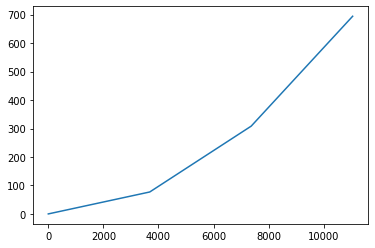

In [148]:
plt.plot(x0, z0)
plt.show()

In [149]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [150]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [151]:
Re_b(Ret),Ws

(array([[[-0.05208686, -0.83043275, -0.55467865],
         [ 0.9160666 ,  0.18142448, -0.35764107],
         [ 0.39762915, -0.52675098,  0.75128188]],
 
        [[ 0.73670999,  0.01092025,  0.67612065],
         [ 0.12965426,  0.9790372 , -0.15708575],
         [-0.66366269,  0.20338857,  0.71985063]],
 
        [[-0.9165569 ,  0.39955404, -0.01673369],
         [ 0.07497092,  0.13057605, -0.98859964],
         [-0.39281397, -0.90736237, -0.14963531]],
 
        [[-0.20664633,  0.86203256,  0.46281439],
         [ 0.29032388, -0.39769608,  0.87037341],
         [ 0.93434969,  0.31422555, -0.1680862 ]]]),
 array([941.76, 941.76, 941.76, 941.76]))

In [152]:
np.einsum('it,ijk->ijk',Ws.reshape(node_N,1),Re_b(Ret))

array([[[ -49.0533244 , -782.06834969, -522.37416225],
        [ 862.7148835 ,  170.85831888, -336.81205777],
        [ 374.47122554, -496.07300762,  707.52722206]],

       [[ 693.80400202,   10.28425331,  636.74338514],
        [ 122.10319741,  922.01807378, -147.93707583],
        [-625.01097076,  191.54321538,  677.92653044]],

       [[-863.17662586,  376.28401542,  -15.7591212 ],
        [  70.60460937,  122.97130046, -931.0236012 ],
        [-369.93648009, -854.51758121, -140.92055102]],

       [[-194.61125241,  811.82778404,  435.86007743],
        [ 273.41542143, -374.53425943,  819.6828615 ],
        [ 879.9331596 ,  295.92504992, -158.29686375]]])

In [153]:
np.einsum('i,ijk->ijk',Ws,Re_b(Ret))

array([[[ -49.0533244 , -782.06834969, -522.37416225],
        [ 862.7148835 ,  170.85831888, -336.81205777],
        [ 374.47122554, -496.07300762,  707.52722206]],

       [[ 693.80400202,   10.28425331,  636.74338514],
        [ 122.10319741,  922.01807378, -147.93707583],
        [-625.01097076,  191.54321538,  677.92653044]],

       [[-863.17662586,  376.28401542,  -15.7591212 ],
        [  70.60460937,  122.97130046, -931.0236012 ],
        [-369.93648009, -854.51758121, -140.92055102]],

       [[-194.61125241,  811.82778404,  435.86007743],
        [ 273.41542143, -374.53425943,  819.6828615 ],
        [ 879.9331596 ,  295.92504992, -158.29686375]]])

In [154]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',Ws,Re_b(Ret)),Z).T 
#     ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [155]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [156]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [157]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [158]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [159]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [160]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [161]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [162]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

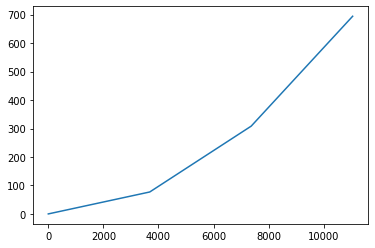

In [163]:
plt.plot(x0_, z0_)
plt.show()

In [164]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,0.1])
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,0.1])

In [165]:
# q0[10*node_N]=q0[8*node_N]=0

In [166]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

### Vessle Sim

In [167]:
sampleTime = 0.01                 # sample time [seconds]
N = 5000                         # number of samples

In [168]:
vehicle=semisub('DPcontrol',10.,-10.,40.0,0,0) 

In [169]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [170]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=0.01

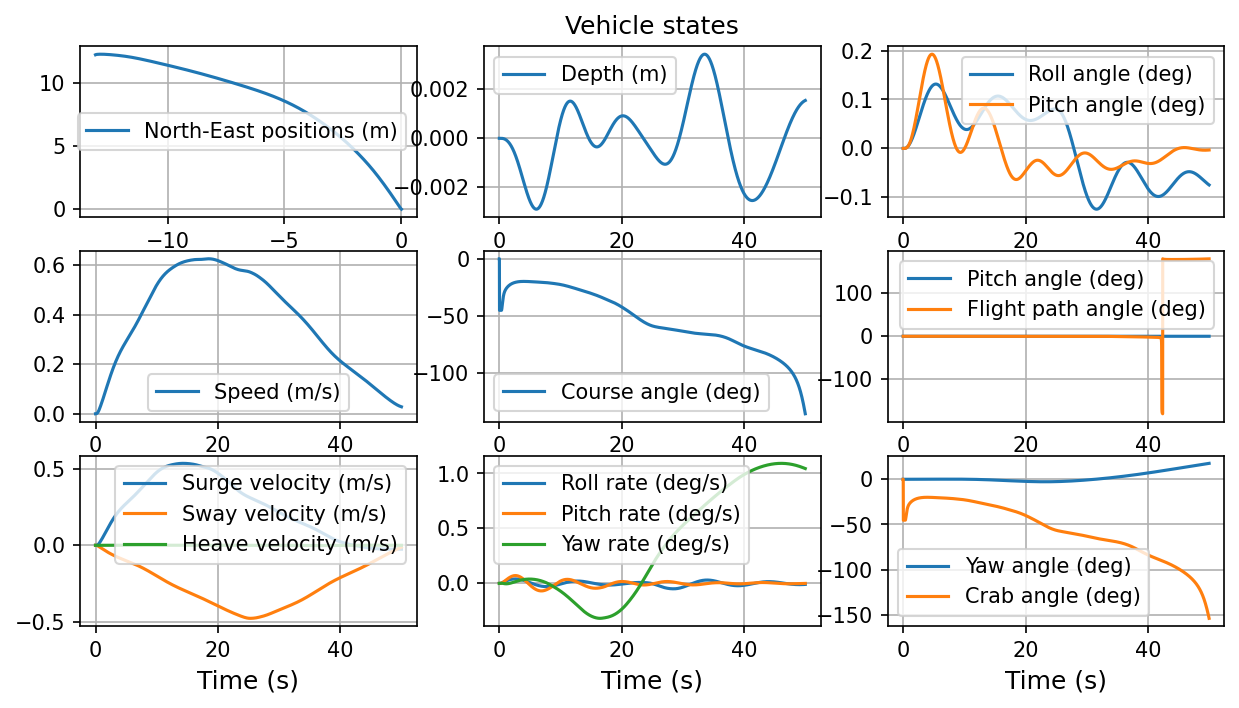

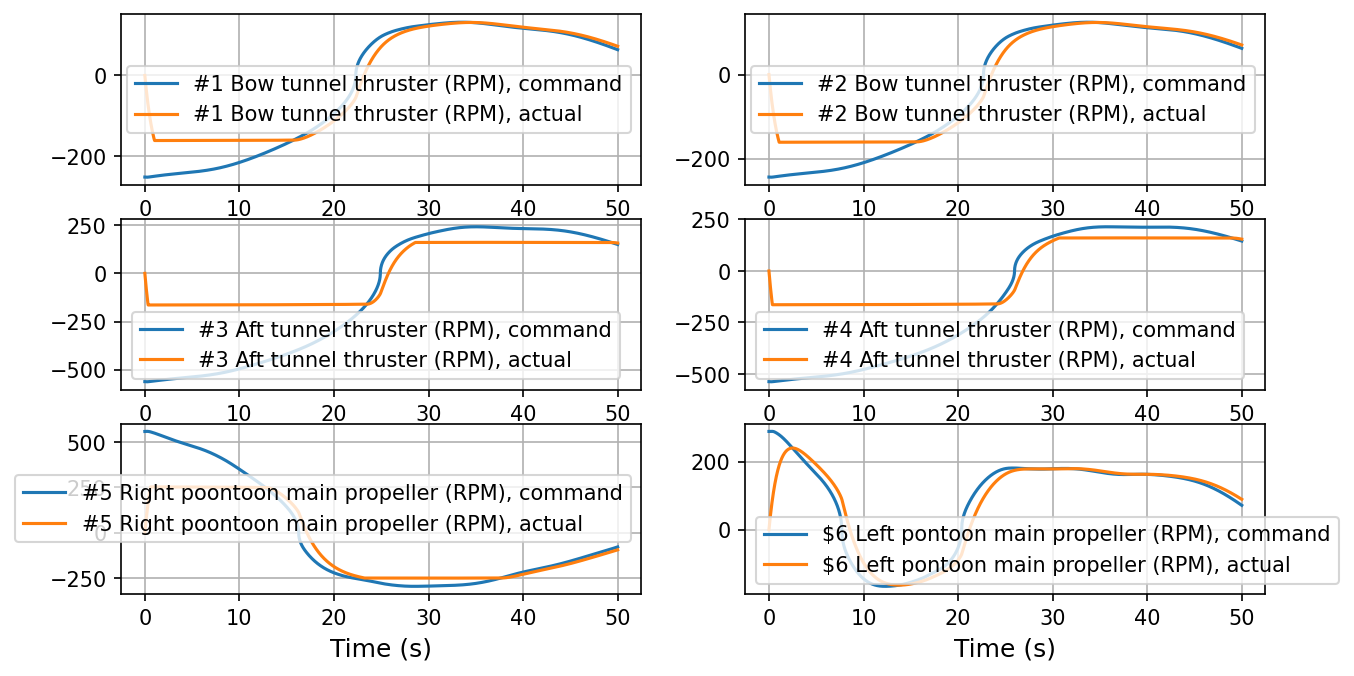

In [171]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [172]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

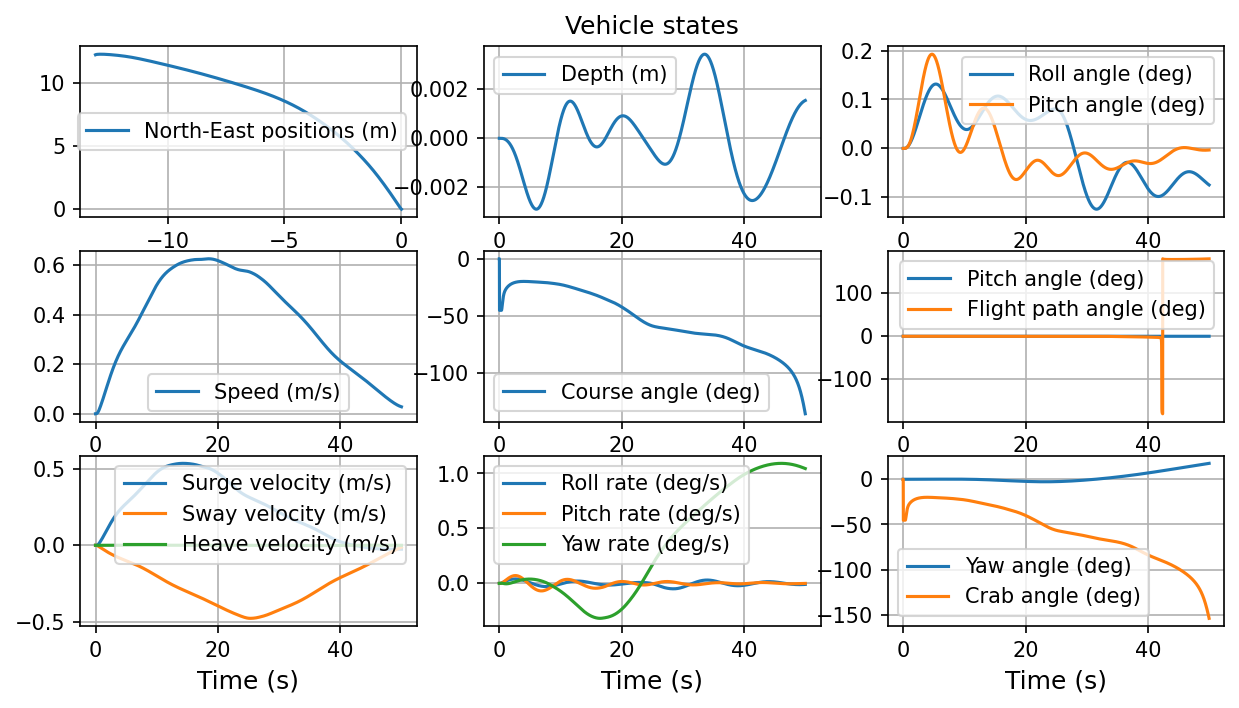

In [173]:
plotVehicleStates(simTime, simData, 3)

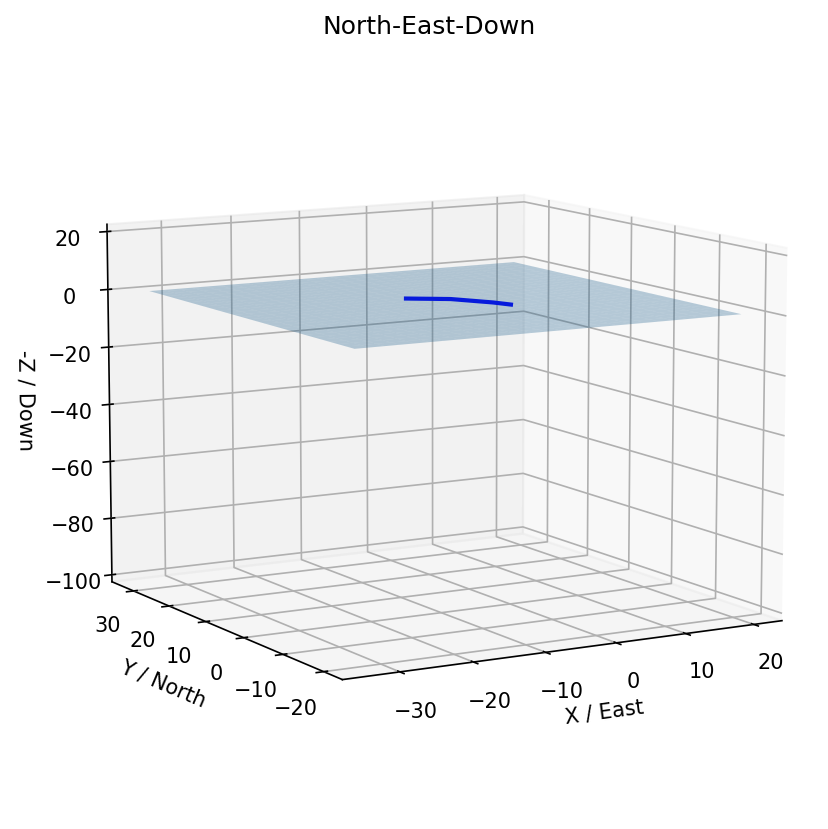

In [174]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [175]:
diff=np.diff(simData,axis=0)
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [181]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
    print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)

    # State vectors
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]

    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
#     du_ve=diff[:, 6][idx]/sampleTime
#     dv_ve = diff[:, 7][idx]/sampleTime
#     dw_ve = diff[:, 8][idx]/sampleTime
#     dp_ve = diff[:, 9][idx]/sampleTime
#     dq_ve = diff[:, 10][idx]/sampleTime
#     dr_ve = diff[:, 11][idx]/sampleTime
    
    
#     η=np.array([x[-1]-x0_[-1], y[-1], z[-1]-z0_[-1], phi_ve, theta_ve, psi_v])
    
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
#     ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
    
    
#     x[-1]=x0[-1]+10*np.sin(t)
#     x[-1]=x0_[-1]+100*np.sin(t)
#     y[-1]+=5*np.cos(t)
#     z[-1]=z0[-1]+2.5*np.sin(t)
#    z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    
    x[-1]+=x_ve
    y[-1]=y_ve
    z[-1]+=z_ve
    dx[-1],dy[-1],dz[-1]=u_ve,v_ve,w_ve
    φ[-1],θ[-1],ψ[-1]=phi_ve,theta_ve,psi_v 
    dφ[-1],dθ[-1],dψ[-1]=p_ve ,q_ve, r_ve
    
    
#     η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
#     dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
#     left=V.eq_left(η,dη)
#     hack =1
#     hack3=1
    
#     # PD controller after 30 sec
#     if t<2:
#         ddη=np.linalg.lstsq(V.M.astype(np.float32), left.astype(np.float32) 
#                             - tau(η, dη, wave_coef, 0, 0, t).astype(np.float32), rcond=None)[0]
#     else:
#         ddη=np.linalg.lstsq(V.M.astype(np.float32), left.astype(np.float32) 
#                             - tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
#                             , rcond=None)[0]
# #     print('ddη', ddη)
 
#     tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force =tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

#     Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret,Z0)
#     print(x,z)
   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
#         +Z0
       )
#     print(Z0, Z1, Z2)
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
#     hack2=1
#     hack4=1
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N-1)]+[vessel_mass/L],RRRR),Z).T 
    
#     for i in range(len(RRRR)):
      
#         a,b,c=np.linalg.lstsq((Ws[i] + vessel_mass)*[i]
# #                               +hack2*np.identity(3)
#                               , Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
# #         print(np.dot(Ws,RRRR[i]))
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
    
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
#     print(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)))
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ #+C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     hack5=1
#     for i in range(len(A)):
# #         if i==len(A)-1:
# #             hack5=vessel_inertia_coef
#         a,b,c=np.linalg.lstsq(A[i]
# #                               +hack2*np.identity(3)
#                               ,B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
# #     ddφ*=np.exp(-t)
#     ddθ*=np.exp(-t)
#     ddψ*=np.exp(-t)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη
#     print(ddφ,ddθ,ddψ)

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [182]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [183]:
# us=ode15s.integrate(10)

In [186]:
tspan = (0., 7)
# tspan = (0., 10)

In [187]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0.0
0.00012577684107025784
0.002515536821405157
0.003773305232107735
0.010062147285620628
0.011180163650689585
0.012577684107025785
0.012577684107025785
0.037733052321077355
0.05031073642810314
0.11319915696323207
0.12437932061392165
0.13835452517728364
0.13835452517728364
0.03290333004767491
0.043066153017999466
0.09388026786962227
0.10291388828768853
0.11420591381027138
0.11420591381027138
0.13453155975092052
0.14469438272124507
0.19550849757286787
0.20454211799093414
0.21583414351351699
0.21583414351351699
0.12481206105804131
0.1301151346819263
0.1566305028013511
0.16134434602258219
0.16723665004912103
0.16723665004912103
0.12243666463656457
0.12655204004971116
0.1471289171154441
0.1507870285937966
0.15535966794173728
0.15535966794173728
0.12129585829107482
0.12484083053147654
0.14256569173348516
0.1457167781693978
0.1496556362142886
0.1496556362142886
0.12023771742452931
0.12325361923165827
0.1383331282673031
0.14101392987363995
0.14436493188156102
0.14436493188156102
0.15039673549

0.5743512919577105
0.5761043426757471
0.5761043426757471
0.5620377038642963
0.5628931126897354
0.567170156816931
0.5679305202173213
0.5688809744678092
0.5688809744678092
0.5617950815967797
0.5625291792884605
0.5661996677468645
0.5668521990283586
0.5676678631302261
0.5676678631302261
0.5616259955717379
0.5622755502508978
0.5655233236466972
0.5661007055837283
0.566822433005017
0.566822433005017
0.5680004095754092
0.5685893978606054
0.571534339286586
0.5720578844289825
0.5727123158569782
0.5727123158569782
0.5829795884590645
0.5881132247601076
0.6137814062653234
0.6183446385329173
0.6240486788674097
0.6240486788674097
0.5764751813904307
0.5783566141571569
0.587763777990788
0.5894361626723226
0.5915266435242406
0.5915266435242406
0.5757205939786054
0.5772247330394189
0.5847454283434868
0.5860824408419878
0.5877537064651139
0.5877537064651139
0.5741049989465461
0.57480134049133
0.5782830482152497
0.5789020184772798
0.5796757313048175
0.5796757313048175
0.5739491144424721
0.5745675137352191


0.7156499229909449
0.7159237954207983
0.7162661359581151
0.7162661359581151
0.7168734821003324
0.717177155171441
0.7186955205269843
0.7189654521457476
0.7193028666692016
0.7193028666692016
0.7244589168334823
0.7270369419156226
0.7399270673263244
0.7422186451771158
0.7450831174906051
0.7450831174906051
0.721599004879776
0.7227470739850632
0.7284874195114993
0.7295079253828657
0.7307835577220737
0.7307835577220737
0.7210391045587161
0.7219072235034734
0.7262478182272596
0.7270194795114883
0.7279840561167741
0.7279840561167741
0.7206912176123634
0.7213853930839443
0.7248562704418489
0.7254733153054763
0.7262446213850107
0.7262446213850107
0.7200183904790414
0.7203761523839612
0.7221649619085606
0.7224829724907116
0.7228804857184004
0.7228804857184004
0.7235960095282401
0.72395377143316
0.7257425809577593
0.7260605915399103
0.7264581047675991
0.7264581047675991
0.7271412427601779
0.7274828117564672
0.7291906567379142
0.7294942736235047
0.729873794730493
0.729873794730493
0.7365516093304948

0.8281245995251152
0.8205870822466845
0.821294132726728
0.8248293851269457
0.8254578744425399
0.8262434860870328
0.8262434860870328
0.8198946397217649
0.8202554689393485
0.8220596150272671
0.8223803521095637
0.8227812734624346
0.8227812734624346
0.823502931897602
0.8238637611151857
0.8256679072031042
0.8259886442854009
0.8263895656382717
0.8263895656382717
0.8270731614482477
0.8274149593532356
0.8291239488781755
0.8294277692381649
0.8298075446881515
0.8298075446881515
0.8366435027879112
0.8400614818377911
0.8571513770871902
0.8601895806870834
0.8639873351869499
0.8639873351869499
0.8335803914182972
0.83546681478337
0.8448989316087343
0.8465757523776879
0.84867177833888
0.84867177833888
0.8313809422635378
0.8321676410512309
0.8361011349896963
0.8368004228009791
0.8376745325650825
0.8376745325650825
0.8310836427854358
0.8317216918340778
0.8349119370772883
0.8354790917871924
0.8361880351745725
0.8361880351745725
0.8304727177776021
0.8308053043223274
0.8324682370459536
0.8327638695301539
0

0.9419595658360285
0.9444269078102329
0.9475110852779884
0.9475110852779884
0.9222370656276145
0.9234788544073275
0.9296877983058923
0.9307916105545261
0.9321713758653183
0.9321713758653183
0.9216214510929996
0.9225554326054051
0.9272253401674326
0.9280555459562376
0.9290933031922437
0.9290933031922437
0.9212407980120727
0.9219844529840148
0.9257027278437251
0.9263637544854514
0.9271900377876092
0.9271900377876092
0.9209929313701519
0.9216126530211335
0.9247112612760418
0.9252621249658033
0.9259507045780051
0.9259507045780051
0.9204137305374299
0.9207438517720506
0.9223944579451542
0.9226878990425947
0.9230547004143955
0.9230547004143955
0.9237149428836369
0.9240450641182576
0.9256956702913611
0.9259891113888017
0.9263559127606025
0.9263559127606025
0.9270031544277489
0.9273267752613221
0.9289448794291881
0.9292325423923644
0.9295921210963346
0.9295921210963346
0.9349488966456049
0.93762728442024
0.9510192232934156
0.9534000124264246
0.9563759988426859
0.9563759988426859
0.932013789868

1.0285159366481984
1.0285159366481984
1.0114970097926201
1.0123197841425908
1.0164336558924445
1.0171650108701964
1.018079204592386
1.018079204592386
1.0112414295880752
1.0119364138357736
1.015411335074265
1.016029098849997
1.0168013035696617
1.0168013035696617
1.0110659002133506
1.0116731197736866
1.0147092175753665
1.0152489682956651
1.0159236566960386
1.0159236566960386
1.010523326224369
1.0108592587902139
1.0125389216194396
1.0128375283446354
1.01321078675113
1.01321078675113
1.0138826518828203
1.0142185844486653
1.015898247277891
1.0161968540030868
1.0165701124095814
1.0165701124095814
1.017248985582059
1.0175884221682978
1.0192856050994918
1.019587326509482
1.0199644782719695
1.0199644782719695
1.0267532099967456
1.0301475758591336
1.047119405171074
1.0501366192709745
1.05390813689585
1.05390813689585
1.023955650629758
1.025951236808652
1.0359291677031233
1.0377030220843626
1.0399203400609118
1.0399203400609118
1.0231386923394552
1.024725799373198
1.0326613345419124
1.03407209634

1.1961769275035814
1.1975539238407296
1.1992751692621648
1.1992751692621648
1.1864741091230613
1.1878191834499678
1.1945445550845013
1.1957401767084184
1.1972347037383146
1.1972347037383146
1.1851130590951873
1.1857776084081568
1.1891003549730048
1.1896910654734223
1.1904294535989441
1.1904294535989441
1.1917585522248835
1.192423101537853
1.195745848102701
1.1963365586031185
1.1970749467286403
1.1970749467286403
1.1983102905374825
1.1989279624419036
1.2020163219640092
1.2025653636568279
1.2032516657728514
1.2032516657728514
1.2109820591141904
1.2148472557848597
1.2341732391382072
1.2376089695121357
1.2419036324795463
1.2419036324795463
1.2063975272668983
1.2079704580139219
1.2158351117490396
1.2172332724130603
1.2189809732430865
1.2189809732430865
1.20595057688043
1.2073000324342191
1.2140473102031655
1.2152468262509781
1.216746221310744
1.216746221310744
1.2045739207955126
1.2052350483068432
1.2085406858634966
1.2091283547624572
1.2098629408861579
1.2098629408861579
1.2111851959088191

1.322885167595624
1.3240463734292527
1.3298524025973963
1.330884585560622
1.332174814264654
1.332174814264654
1.322333181131344
1.3232183937328328
1.3276444567402765
1.3284313123860443
1.329414881943254
1.329414881943254
1.3219877089606376
1.3227001854767733
1.3262625680574516
1.3268958805162387
1.3276875210897228
1.3276875210897228
1.321760532927118
1.3223594214264938
1.3253538639233726
1.3258862092561512
1.3265516409221243
1.3265516409221243
1.3216051369704531
1.3221263274914967
1.3247322800967138
1.3251955605598635
1.3257746611388006
1.3257746611388006
1.32113760415933
1.3214250282748117
1.3228621488522208
1.3231176369548712
1.3234369970831843
1.3234369970831843
1.3240118453141478
1.3242992694296296
1.3257363900070387
1.325991878109689
1.3263112382380022
1.3263112382380022
1.3268906277613723
1.3271803225230574
1.3286287963314827
1.3288863027863138
1.3292081858548528
1.3292081858548528
1.334482404571929
1.3371195139304672
1.3503050607231581
1.3526491579307476
1.3555792794402344
1.355

1.428678206747087
1.4289576693714905
1.429306997651995
1.429306997651995
1.4325232096704863
1.4341313156797317
1.4421718457259598
1.4436012732897339
1.4453880577444511
1.4453880577444511
1.430756489459711
1.431481235363569
1.435104964882859
1.435749183464066
1.436554456690575
1.436554456690575
1.4304300072231868
1.4309915120087828
1.4337990359367627
1.4342981513017368
1.4349220455079545
1.4349220455079545
1.4360450550791464
1.4366065598647424
1.4394140837927223
1.4399131991576963
1.4405370933639141
1.4405370933639141
1.441632335692487
1.4421799568567732
1.4449180626782054
1.44540483704646
1.4460133050067783
1.4460133050067783
1.4410868584712575
1.441361741024929
1.4427361537932875
1.4429804938409956
1.4432859189006308
1.4432859189006308
1.4438356840079742
1.4441105665616458
1.4454849793300042
1.4457293193777123
1.4460347444373476
1.4460347444373476
1.44654866635188
1.4468056273091463
1.4480904320954775
1.4483188418352697
1.44860435401001
1.44860435401001
1.4518498873401102
1.4534726540

1.5652627913574162
1.5652627913574162
1.5632161266862625
1.563345704475412
1.5639935934211593
1.5641087736781811
1.5642527489994582
1.5642527489994582
1.5645119045777571
1.5646414823669066
1.5652893713126539
1.5654045515696757
1.5655485268909528
1.5655485268909528
1.5658136913514553
1.5659462735817065
1.5666091847329626
1.566727035604297
1.5668743491934651
1.5668743491934651
1.56863911351654
1.5695214956780774
1.5739334064857644
1.574717746184909
1.5756981708088393
1.5756981708088393
1.5677426429061614
1.5681767897625094
1.5703475240442502
1.570733432361004
1.5712158177569464
1.5712158177569464
1.5720841114696427
1.572518258325991
1.5746889926077314
1.5750749009244853
1.5755572863204277
1.5755572863204277
1.5716440289039186
1.5718581344774045
1.5729286623448349
1.5731189784101558
1.573356873491807
1.573356873491807
1.5737850846387793
1.5739991902122652
1.5750697180796955
1.5752600341450165
1.5754979292266678
1.5754979292266678
1.5758926163972211
1.5760899599824978
1.577076677908881
1.5

1.6783277098604965
1.6787757328821578
1.6793357616592344
1.6793357616592344
1.6752014149186814
1.6756543710452494
1.6779191516780898
1.6783217793461505
1.678825063931226
1.678825063931226
1.6796566937886674
1.680072508717388
1.6821515833609912
1.6825211966309652
1.6829832132184326
1.6829832132184326
1.6872905638311573
1.6894442391375197
1.7002126156693318
1.7021269937194317
1.7045199662820565
1.7045199662820565
1.6856514703817458
1.6869855989634026
1.6936562418716858
1.6948421339442694
1.696324499034999
1.696324499034999
1.684163743774793
1.684754009052973
1.6877053354438736
1.688230015691145
1.688885866000234
1.688885866000234
1.6838402647593804
1.6842687905298541
1.6864114193822235
1.6867923311782003
1.6872684709231713
1.6872684709231713
1.6836465622222816
1.6839782367242062
1.6856366092338289
1.6859314310133173
1.6862999582376779
1.6862999582376779
1.6835236378511873
1.6837938501675647
1.6851449117494512
1.6853851004751201
1.685685336382206
1.685685336382206
1.6834419248872021
1.683

1.7552387827618263
1.7524117413056026
1.7525945943801657
1.7535088597529818
1.7536713958192602
1.7538745659021082
1.7538745659021082
1.7542402720512347
1.7544231251257978
1.7553373904986138
1.7554999265648923
1.7557030966477403
1.7557030966477403
1.7560335286467315
1.756198744646227
1.7570248246437048
1.7571716833099231
1.757355256642696
1.757355256642696
1.7590588768856232
1.759910687007087
1.7641697376144054
1.7649269021668175
1.7658733578573327
1.7658733578573327
1.758155625512286
1.7585558099470813
1.7605567321210567
1.7609124516186523
1.7613571009906468
1.7613571009906468
1.762157469860237
1.762557654295032
1.7645585764690075
1.764914295966603
1.7653589453385976
1.7653589453385976
1.7617944477434508
1.7620131211198529
1.7631064880018628
1.7633008643364423
1.7635438347546668
1.7635438347546668
1.7639811815074709
1.7641998548838729
1.7652932217658828
1.7654875981004623
1.7657305685186868
1.7657305685186868
1.7639244245326053
1.7641147194215745
1.765066193866421
1.765235344878838
1.7

1.84983056847394
1.84983056847394
1.8458313987367034
1.8462573739962866
1.8483872502942018
1.8487658949693866
1.8492392008133678
1.8492392008133678
1.8500069584977294
1.8503908373399103
1.8523102315508144
1.8526514571883086
1.853077989235176
1.853077989235176
1.8568815776983099
1.8587833719298767
1.868292343087711
1.8699828268491039
1.8720959315508447
1.8720959315508447
1.8554314219014938
1.8566081382346526
1.8624917199004472
1.863537689974366
1.8648451525667649
1.8648451525667649
1.8548075042085603
1.8556722616952523
1.859996049128713
1.8607647224502173
1.8617255641020973
1.8617255641020973
1.8544297407475303
1.8551056165037074
1.8584849952845932
1.8590857737345283
1.8598367467969474
1.8598367467969474
1.8541877784504965
1.8547426730581567
1.857517146096458
1.8580103857477115
1.8586269353117784
1.8586269353117784
1.8538703950999416
1.8542665980323243
1.8562476126942378
1.856599793078578
1.8570400185590032
1.8570400185590032
1.8536831959180469
1.8539857992594821
1.855498815966659
1.855

1.9263360296277285
1.9263360296277285
1.927390575149587
1.9279178479105161
1.9305542117151622
1.9310228986137659
1.9316087572370206
1.9316087572370206
1.9358052333221347
1.9379034713646919
1.9483946615774774
1.9502597620597504
1.9525911376625915
1.9525911376625915
1.9341487627203797
1.9354187654620594
1.9417687791704574
1.9428976704963947
1.9443087846538165
1.9443087846538165
1.9334402024862247
1.9343559251108267
1.938934538233837
1.93974851390015
1.940765983483041
1.940765983483041
1.9327874104102973
1.9333767369969355
1.936323369930127
1.9368472157849166
1.9375020231034037
1.9375020231034037
1.9324371926158697
1.9328514103052943
1.9349224987524172
1.9352906922541278
1.9357509341312662
1.9357509341312662
1.9319938400030099
1.9321863813860047
1.933149088300978
1.9333202361969732
1.9335341710669673
1.9335341710669673
1.9339192538329566
1.9341117952159514
1.9350745021309248
1.93524565002692
1.935459584896914
1.935459584896914
1.9338727007336658
1.934041965567015
1.934888289733761
1.93503

1.9981734846599142
1.9981734846599142
1.9946350149237948
1.9950212751833365
1.9969525764810443
1.99729591893397
1.9977250970001275
1.9977250970001275
1.9984326977678932
1.998786498151776
2.0005555000711905
2.0008699893013087
2.001263100838956
2.001263100838956
2.0043469208629636
2.0058888308749676
2.013598380934986
2.014968967612323
2.0166822009589938
2.0166822009589938
2.0025525598447858
2.003197289347701
2.0064209368622756
2.006994029753755
2.0077103958681053
2.0077103958681053
2.002154835310595
2.002600702546414
2.0048300387255105
2.00522636515735
2.0057217731971493
2.0057217731971493
2.0016722576799433
2.001876836100437
2.0028997282029053
2.0030815756877884
2.0033088850438925
2.0033088850438925
2.0037180418848797
2.0039226203053735
2.0049455124078417
2.005127359892725
2.005354669248829
2.005354669248829
2.003528273447919
2.0036379676499325
2.0041864386599997
2.004283944617345
2.0044058270640264
2.0044058270640264
2.004625215468053
2.0047349096700664
2.0052833806801336
2.00538088663

2.072364772320757
2.0725438820711424
2.0734394308230697
2.0735986394900787
2.0737976503238404
2.0737976503238404
2.074155869824611
2.0743349795749966
2.075230528326924
2.075389736993933
2.0755887478276946
2.0755887478276946
2.074119643869693
2.0742806406426193
2.075085624507251
2.075228732749852
2.0754076180531036
2.0754076180531036
2.0757032880271846
2.0758511230142256
2.0765902979494286
2.076721706826798
2.0768859679235097
2.0768859679235097
2.078314338997895
2.079028524535088
2.0825994522210514
2.083234283809667
2.0840278232954366
2.0840278232954366
2.090161069455126
2.0932276925349704
2.1085608079341935
2.1112866951162776
2.114694054093883
2.114694054093883
2.0868846974319015
2.0883131345001336
2.0954553198412955
2.0967250416797243
2.0983121939777605
2.0983121939777605
2.0859160367154805
2.0868601434255027
2.0915806769756133
2.092419882940077
2.0934688903956573
2.0934688903956573
2.0854854123432243
2.0862142068671186
2.0898581794865883
2.0905059968411606
2.091315768534376
2.0913157

2.17322949351533
2.17322949351533
2.1643920514749526
2.1651905317869153
2.1691829333467307
2.1698926936240315
2.170779893970657
2.170779893970657
2.164084413027182
2.1647290741152596
2.167952379555649
2.1685254116339405
2.1692417017318046
2.1692417017318046
2.1637034156679933
2.164157578076477
2.166428390118894
2.1668320900375457
2.167336714935861
2.167336714935861
2.163481436276424
2.1638246089891227
2.1655404725526166
2.1658455149639044
2.166226817978014
2.166226817978014
2.163343601327375
2.163617856565549
2.16498913275642
2.1652329151903524
2.1655376432327684
2.1655376432327684
2.1630776352873946
2.1632189075055783
2.1639252685964987
2.1640508439015513
2.164207813032867
2.164207813032867
2.1644903574692353
2.164631629687419
2.1653379907783394
2.165463566083392
2.1656205352147078
2.1656205352147078
2.1658901826724613
2.166025006401338
2.1666991250457217
2.1668189683602788
2.166968772503475
2.166968772503475
2.168182345879052
2.1687891325668405
2.171823066005782
2.1723624319504826
2.

2.2351899167672955
2.2351899167672955
2.2335400880659666
2.233662023768624
2.234271702281913
2.2343800895731647
2.234515573687229
2.234515573687229
2.2347594450925445
2.234881380795202
2.235491059308491
2.2355994465997426
2.235734930713807
2.235734930713807
2.235976939195216
2.23609794343592
2.236702964639442
2.2368105239645124
2.236944973120851
2.236944973120851
2.238005613497678
2.2385359336860913
2.2411875346281582
2.2416589303511927
2.242248175004985
2.242248175004985
2.2463967036872914
2.2484709680284447
2.2588422897342104
2.26068608025968
2.2629908184165166
2.2629908184165166
2.2448464909173214
2.246145648873489
2.252641438654329
2.2537962457264786
2.255239754566665
2.255239754566665
2.243405864413052
2.2439847091170853
2.2468789326372516
2.247393461263059
2.2480366220453183
2.2480366220453183
2.2430903389748105
2.243511420959723
2.2456168308842863
2.2459911259819862
2.2464589948541116
2.2464589948541116
2.2429010835144116
2.243227537769125
2.2448598090426906
2.2451499906024357
2

2.3137325283241643
2.31514128192717
2.315391727012149
2.3157047833683726
2.3157047833683726
2.313360975895572
2.313597825762178
2.3147820750952057
2.3149926083099666
2.315255774828417
2.315255774828417
2.3131794070347462
2.3133254724709387
2.314055799651902
2.314185635595184
2.314347930524287
2.314347930524287
2.3146400613966724
2.314786126832865
2.315516454013828
2.3156462899571104
2.3158085848862133
2.3158085848862133
2.3160886454123206
2.3162286756753745
2.3169288269906434
2.31705329833558
2.3172088875167507
2.3172088875167507
2.318285496419575
2.318823800870988
2.3215153231280494
2.321993815973749
2.322591932030874
2.322591932030874
2.3266539589746276
2.3286849724465046
2.3388400398058895
2.3406453851142244
2.342902066749643
2.342902066749643
2.3251355259874207
2.326407322965694
2.332766307857061
2.333896794059971
2.335309901813608
2.335309901813608
2.323726660477076
2.324294024700177
2.3271308458156823
2.32763516956955
2.3282655742618843
2.3282655742618843
2.3234202960466885
2.323

2.396526781227133
2.396526781227133
2.382082512559049
2.382744855621441
2.3860565709334023
2.3866453203221956
2.3873812570581867
2.3873812570581867
2.381681644590036
2.3821435536679214
2.3844530990573496
2.384863684904359
2.385376917213121
2.385376917213121
2.381248448112264
2.381493758951264
2.3827203131462626
2.3829383672253734
2.383210934824262
2.383210934824262
2.3837015565022615
2.3839468673412614
2.38517342153626
2.385391475615371
2.3856640432142595
2.3856640432142595
2.383628281344116
2.383836954604043
2.384880320903678
2.385065808245835
2.385297667423532
2.385297667423532
2.3834369180471673
2.3835499096586203
2.384114867715884
2.3842153047038415
2.384340850938789
2.384340850938789
2.3845668341616943
2.3846798257731474
2.385244783830411
2.3853452208183685
2.385470767053316
2.385470767053316
2.385695235946402
2.385807470392945
2.3863686426256594
2.386468406578142
2.3865931115187453
2.3865931115187453
2.387512179101707
2.3879717128931874
2.3902693818505916
2.3906778563319078
2.391

2.4715867324327094
2.471989326906561
2.474002299275818
2.4743601610303525
2.4748074882235205
2.4748074882235205
2.475612677171223
2.4760152716450747
2.4780282440143315
2.478386105768866
2.478833432962034
2.478833432962034
2.475516608221577
2.475871168220605
2.4776439682157467
2.4779591326593273
2.478353088213803
2.478353088213803
2.4789935357316395
2.479313759490558
2.480914878285149
2.4811995216264093
2.481555325802985
2.481555325802985
2.48351246637156
2.4844910366558475
2.489383888077285
2.4902537283299853
2.49134102864586
2.49134102864586
2.48275440887283
2.4833539504077526
2.486351658082365
2.486884583891185
2.48755074115221
2.48755074115221
2.482365544101659
2.4827706532509963
2.4847961989976812
2.485156296019314
2.485606417296355
2.485606417296355
2.48192024926994
2.4821027110034173
2.4830150196708045
2.48317720787834
2.4833799431377592
2.4833799431377592
2.483744866604714
2.4839273283381913
2.4848396370055785
2.485001825213114
2.4852045604725332
2.4852045604725332
2.48357273059

2.5547287997591623
2.5547287997591623
2.554848946210052
2.5549090194354966
2.55520938556272
2.5552627839853375
2.5553295320136096
2.5553295320136096
2.55545238678359
2.5555138141685805
2.5558209510935317
2.555875553213523
2.555943805863512
2.555943805863512
2.556450745894418
2.556704215909871
2.557971565987136
2.558196872667539
2.558478506018042
2.558478506018042
2.5601810167979955
2.561032272187972
2.5652885491378554
2.5660452205956124
2.5669910599178087
2.5669910599178087
2.55949606344825
2.5600048421633534
2.5625487357388725
2.5630009834856318
2.5635662931690804
2.5635662931690804
2.564583850599288
2.5650926293143916
2.5676365228899107
2.56808877063667
2.5686540803201185
2.5686540803201185
2.5643725166028934
2.5647756283198
2.5667911869043336
2.5671495084304725
2.5675974103381467
2.5675974103381467
2.5641258692492
2.5644056572892597
2.5658045974895587
2.566053297969612
2.5663641735696783
2.5663641735696783
2.563984106129122
2.5641930126091426
2.565237545009246
2.5654232396581533
2.5

2.6350566708625744
2.6293901383966296
2.6296572511620036
2.6309928149888737
2.631230248558095
2.6315270405196216
2.6315270405196216
2.6320612660503695
2.6323283788157434
2.6336639426426136
2.633901376211835
2.6341981681733615
2.6341981681733615
2.635954314012954
2.636832386932751
2.6412227515317324
2.6420032607937736
2.642978897371325
2.642978897371325
2.6353890736003396
2.6359845263138286
2.6389617898812734
2.6394910811821526
2.6401526953082515
2.6401526953082515
2.635071082070485
2.6355075390190468
2.6376898237618556
2.6380777854939104
2.638562737658979
2.638562737658979
2.634878987114456
2.6352193965850033
2.63692144393774
2.637224030133782
2.6376022628788345
2.6376022628788345
2.634756243985353
2.6350352818913487
2.6364304714213276
2.636678505115546
2.636988547233319
2.636988547233319
2.634674155075255
2.6349121485262015
2.6361021157809352
2.63631366551511
2.6365781026828286
2.6365781026828286
2.6345486316108793
2.6347238633296377
2.6356000219234317
2.6357557834512173
2.63595048536

2.694028202698719
2.6951758805779984
2.700914269974396
2.7019344280893116
2.7032096257329554
2.7032096257329554
2.69315334513587
2.693863594233725
2.697414839723
2.6980461722544264
2.6988353379187098
2.6988353379187098
2.6925420394843096
2.6929466357563845
2.6949696171167594
2.695329258247493
2.695778809660909
2.695778809660909
2.6920507486847636
2.6922096995570657
2.693004453918576
2.693145743582844
2.6933223556631796
2.6933223556631796
2.6936402574077833
2.6937992082800855
2.6945939626415956
2.694735252305864
2.6949118643861993
2.6949118643861993
2.695993141886064
2.696533780635996
2.6992369743856566
2.6997175421633743
2.700318251885521
2.700318251885521
2.6956897678124356
2.6960787195255533
2.6980234780911436
2.6983692129472487
2.69880138151738
2.69880138151738
2.695509574799322
2.6958084300058833
2.6973027060386903
2.697568355111189
2.6979004164518128
2.6979004164518128
2.6953959569161148
2.695638003181073
2.696848234505862
2.69706338674138
2.6973323270357774
2.6973323270357774
2.6

2.744937538736131
2.744993786708167
2.7450640966732123
2.7450640966732123
2.744511709398336
2.7445519106036014
2.7447529166299263
2.744788651034606
2.744833319040456
2.744833319040456
2.744913721450986
2.744953922656251
2.745154928682576
2.745190663087256
2.745235331093106
2.745235331093106
2.7453142697129014
2.745353739022799
2.745551085572288
2.7455861694033086
2.7456300241920837
2.7456300241920837
2.7459323020018886
2.7460834409067916
2.7468391354313044
2.746973481124551
2.7471414132411094
2.7471414132411094
2.7481528985410577
2.7486586411910316
2.751187354440902
2.751636903463101
2.75219883974085
2.75219883974085
2.7549301793147367
2.7562958491016802
2.7631241980363965
2.7643381267359017
2.765855537610283
2.765855537610283
2.7531407209565697
2.7536116615644293
2.7559663646037276
2.7563849784773806
2.756908245819447
2.756908245819447
2.7527608586698835
2.7530418681344004
2.7544469154569846
2.7546967016476662
2.755008934386018
2.755008934386018
2.7524623007501456
2.752594031254793
2.

2.805454220506279
2.8059073564397825
2.8081730361072994
2.808575823603747
2.809079307974306
2.809079307974306
2.805181600170368
2.8054984259359164
2.807082554763656
2.8073641776663654
2.807716206294752
2.807716206294752
2.805023884965754
2.805261853128995
2.8064516939451982
2.806663221201412
2.8069276302716797
2.8069276302716797
2.804926458008605
2.8051157126932713
2.8060619861166023
2.8062302125029723
2.8064404954859348
2.8064404954859348
2.8048631176278036
2.805020702122069
2.8058086245933977
2.8059486996994116
2.806123793581929
2.806123793581929
2.8048201497121394
2.8049562502485728
2.8056367529307407
2.805757731185348
2.8059089540036077
2.8059089540036077
2.8047503891309256
2.804851609376752
2.805357710605885
2.805447684157731
2.8055601510975383
2.8055601510975383
2.804707684173308
2.804787551940325
2.8051868907754134
2.805257884346096
2.805346626309449
2.805346626309449
2.8046801082030424
2.8047461879849274
2.805076586894353
2.8051353244782504
2.805208746458123
2.805208746458123
2

2.851525440277054
2.8537576686430306
2.8548737828260187
2.8604543537409604
2.86144645523695
2.862686582106937
2.862686582106937
2.8525866971694147
2.8531173256155955
2.8557704678464977
2.8562421375764355
2.8568317247388584
2.8568317247388584
2.852110899925142
2.852403629749186
2.8538672788694055
2.854127483157445
2.8544527385174936
2.8544527385174936
2.8550381981655817
2.8553309279896255
2.856794577109845
2.8570547813978844
2.857380036757933
2.857380036757933
2.854887741496295
2.8551052429856956
2.856192750432699
2.8563860850899445
2.8566277534115008
2.8566277534115008
2.8547957332171503
2.8549672305669787
2.855824717316121
2.855977159404857
2.8561677120157776
2.8561677120157776
2.854689912936118
2.85480850014543
2.8554014361919915
2.855506847044713
2.8556386106106157
2.8556386106106157
2.854629301650552
2.8547175832170817
2.855158991049729
2.85523746355331
2.8553355541827874
2.8553355541827874
2.854592171355391
2.85466188777434
2.855010469869084
2.855072440019261
2.8551499027069815
2.

2.8953230618951245
2.8960075505264267
2.8961292373942134
2.8962813459789474
2.8962813459789474
2.895144456490451
2.895260500377505
2.8958407198127754
2.895943869934601
2.8960728075868833
2.8960728075868833
2.8951157131503025
2.8952173853672827
2.895725746452182
2.8958161217561638
2.8959290908861415
2.8959290908861415
2.8950952863941373
2.8951867452330347
2.8956440394275207
2.895725336173207
2.895826957105315
2.895826957105315
2.8959950159760144
2.896079045411364
2.896499192588112
2.896573885419534
2.8966672514588114
2.8966672514588114
2.8971790173734266
2.897434900330734
2.898714315117272
2.8989417666348785
2.899226081031887
2.899226081031887
2.900560950048009
2.9012283845560702
2.9045655570963755
2.905158832214652
2.9059004261124977
2.9059004261124977
2.8996487606416435
2.8998601004465216
2.9009167994709126
2.901104657075249
2.901339479080669
2.901339479080669
2.9017621586904254
2.9019734984953036
2.9030301975196946
2.903218055124031
2.903452877129451
2.903452877129451
2.9046388695474

2.9457833134715186
2.9458714829982253
2.945981694906609
2.945981694906609
2.9451648470152056
2.9452523766572294
2.9456900248673485
2.945767828993592
2.945865084151396
2.945865084151396
2.946023482891602
2.9461026822617047
2.9464986791122194
2.946569078552311
2.9466570778524255
2.9466570778524255
2.9471479867011467
2.9473934411255076
2.9486207132473106
2.9488388949578535
2.949111622096032
2.949111622096032
2.950382139578774
2.951017398320145
2.954193692027001
2.9547583664637753
2.9554642095097434
2.9554642095097434
2.9495677417997386
2.949795801651592
2.9509361009108597
2.9511388207791738
2.9513922206145664
2.9513922206145664
2.951848340318273
2.9520764001701267
2.9532166994293942
2.9534194192977083
2.953672819133101
2.953672819133101
2.9549342460545422
2.9555649595152627
2.958718526818866
2.9592791610061733
2.9599799537403073
2.9599799537403073
2.9544381094543204
2.9548207546149303
2.9567339804179786
2.9570741094496316
2.957499270739198
2.957499270739198
2.9541019554193313
2.9543165235

2.986081231967806
2.986081231967806
2.986575418871548
2.986822512323419
2.988057979582774
2.9882776182066593
2.988552166486516
2.988552166486516
2.9898053153629
2.990431889801092
2.993564761992052
2.9941217170482224
2.9948179108684356
2.9948179108684356
2.9973363073040313
2.9985955055218287
3.0048914966108176
3.006010783915527
3.0074098930464133
3.0074098930464133
2.9954838027431094
2.995816748680446
2.9974814783671304
2.9977774303114297
2.998147370241804
2.998147370241804
2.9952686666099813
2.9954940444807536
2.9966209338346173
2.996821269719749
2.997071689576163
2.997071689576163
2.995147821306046
2.9953127765248517
2.9961375526188783
2.9962841794800386
2.9964674630564887
2.9964674630564887
2.995074925648191
2.9952034330380695
2.995845969987459
2.9959601987784614
2.9961029847672145
2.9961029847672145
2.99502837905506
2.995133613148372
2.995659783614933
2.99575332503121
2.995870251801557
2.995870251801557
2.994997314634221
2.995087016517114
2.995535525931578
2.9956152609385938
2.99571

3.0482945867989546
3.043398639849384
3.043671861651439
3.0450379706617126
3.045280834485761
3.045584414265822
3.045584414265822
3.043167075662173
3.043324515370622
3.0441117139128675
3.044251660320378
3.044426593329766
3.044426593329766
3.044741472746664
3.044898912455113
3.0456861109973588
3.0458260574048692
3.046000990414257
3.046000990414257
3.044629180311119
3.0447304738017955
3.045236941255178
3.045326979913557
3.045439528236531
3.045439528236531
3.044568956848904
3.0446401386084734
3.0449960474063196
3.045059320081492
3.045138410925458
3.045138410925458
3.044492749472488
3.0445258275438496
3.0446912179006556
3.044720620630754
3.0447573740433778
3.0447573740433778
3.0448235301861
3.0448566082574615
3.0450219986142675
3.045051401344366
3.0450881547569897
3.0450881547569897
3.0448155278674163
3.0448446047794357
3.0449899893395327
3.0450158354835497
3.045048143163571
3.045048143163571
3.0447896968268715
3.0448058582186186
3.0448866651773536
3.0449010308589064
3.0449189879608474
3.044

3.085451381063308
3.0855353397240055
3.085955133027492
3.0860297629481117
3.0861230503488866
3.0861230503488866
3.0866245013951428
3.086875226918271
3.088128854533911
3.0883517216655805
3.088630305580167
3.088630305580167
3.089843415522301
3.090449970493368
3.093482745348703
3.0940219053229847
3.094695855290837
3.094695855290837
3.097093032212582
3.098291620673454
3.104284562977816
3.1053499749430364
3.106681739899561
3.106681739899561
3.095309494047958
3.095616313426518
3.0971504103193204
3.0974231386558184
3.0977640490764413
3.0977640490764413
3.095100436229344
3.0953027266985975
3.0963141790448647
3.0964939927953123
3.096718759983372
3.096718759983372
3.0949858002755133
3.0951307727678516
3.095855635229543
3.0959844996671766
3.0961455802142193
3.0961455802142193
3.0949179541643503
3.095029003601107
3.095584250784891
3.0956829613953416
3.0958063496584045
3.0958063496584045
3.0948752883700656
3.09496500490968
3.095413587607752
3.095493335642965
3.0955930206869806
3.0955930206869806
3.

3.135122229514004
3.1351397372674628
3.1352272760347537
3.135242838482272
3.13526229154167
3.13526229154167
3.1353939377473248
3.1354597608501527
3.1357888763642903
3.1358473857890257
3.135920522569945
3.135920522569945
3.1363226689602204
3.136523742155358
3.1375291081310466
3.1377078398600577
3.137931254521322
3.137931254521322
3.138876599430723
3.139349271885424
3.1417126341589277
3.142132787451995
3.142657979068329
3.142657979068329
3.144587102075363
3.14555166357888
3.150374471096465
3.151231859099591
3.152303594103499
3.152303594103499
3.1436493874247833
3.1441450916030105
3.146623612494147
3.1470642384303487
3.1476150208506013
3.1476150208506013
3.1431447986282293
3.1433882084081795
3.144605257307931
3.1448216215567752
3.145092076867831
3.145092076867831
3.1428532441273145
3.142950876656807
3.143439039304271
3.1435258237749313
3.1436343043632564
3.1436343043632564
3.143829569422242
3.1439272019517346
3.1444153645991983
3.144502149069859
3.144610629658184
3.144610629658184
3.14514

3.1833365687390107
3.1839161061109245
3.184019134977042
3.1841479210596897
3.1841479210596897
3.1847353673361867
3.185029090474435
3.186497706165677
3.186758793399676
3.187085152442174
3.187085152442174
3.1845250100322415
3.1847135545185172
3.185656276949896
3.1858238720488083
3.186033365922448
3.186033365922448
3.1843691504882785
3.184479765202573
3.1850328387740454
3.185131162964529
3.1852540682026342
3.1852540682026342
3.1842923220095662
3.184364522484505
3.184725524859197
3.184789703059142
3.1848699258090734
3.1848699258090734
3.18501432675895
3.1850865272338886
3.1854475296085805
3.1855117078085255
3.185591930558457
3.185591930558457
3.184992652530836
3.185054015891717
3.1853608326961225
3.185415377905795
3.185483559417885
3.185483559417885
3.1849776593306736
3.185031526091474
3.185300859895475
3.1853487414606305
3.1854085934170753
3.1854085934170753
3.1855056719230523
3.1855542111760413
3.1857969074409844
3.185840053443641
3.1858939859469615
3.1858939859469615
3.186184063600279
3

3.235862122447222
3.2350539058909176
3.235129517069224
3.2355075729607545
3.2355747828970265
3.2356587953173666
3.2356587953173666
3.235027680204884
3.2350901785401738
3.2354026702166205
3.235458224292433
3.235527666887199
3.235527666887199
3.235010013035802
3.2350636777865507
3.235332001540293
3.235379703540958
3.2354393310417895
3.2354393310417895
3.2349976945635928
3.2350452000782366
3.235282727651455
3.2353249547755825
3.235377738680742
3.235377738680742
3.2354639177080124
3.2355070072216474
3.235722454789823
3.235760756579721
3.2358086338170935
3.2358086338170935
3.2360635396724535
3.2361909926001338
3.2368282572385345
3.2369415487298054
3.2370831630938945
3.2370831630938945
3.2377175609448057
3.2380347598702612
3.2396207544975386
3.2399027090979438
3.2402551523484497
3.2402551523484497
3.241595144940511
3.2422651412365417
3.2456151227166954
3.2462106749798334
3.2469551153087566
3.2469551153087566
3.240851863047964
3.2411502183977214
3.2426419951465073
3.242907199901847
3.24323870

3.285805775454013
3.2800820751583704
3.2802492950344573
3.281085394414891
3.2812340343047457
3.2814198341670644
3.2814198341670644
3.281754273919238
3.2819214937953247
3.2827575931757584
3.282906233065613
3.283092032927932
3.283092032927932
3.283862209540035
3.2842472978460866
3.2861727393763447
3.286515040092835
3.286942915988448
3.286942915988448
3.2834697447468804
3.283658600656355
3.284602880203727
3.284770752123259
3.2849805920226753
3.2849805920226753
3.285358303841624
3.2855471597510983
3.2864914392984703
3.2866593112180027
3.286869151117419
3.286869151117419
3.285235976126481
3.2853636681783835
3.2860021284378975
3.2861156324840337
3.2862575125417033
3.2862575125417033
3.2851673127669434
3.2852606731390774
3.285727474999747
3.2858104619971997
3.285914195744015
3.285914195744015
3.2851259369144494
3.2851986093603367
3.2855619715897726
3.28562656931945
3.2857073164815467
3.2857073164815467
3.285099546130994
3.2851590231851535
3.28545640845595
3.285509276948536
3.2855753625642685


3.335092715037183
3.3352524160314823
3.3360509210029767
3.3361928774423535
3.3363703229915744
3.3363703229915744
3.3349928214127087
3.33510257559477
3.3356513465050783
3.335748905778022
3.3358708548692015
3.3358708548692015
3.334935923417813
3.335017228602427
3.3354237545254954
3.335496025800708
3.335586364894723
3.335586364894723
3.3349012198929304
3.3349651733151027
3.3352849404259644
3.33534178791234
3.3354128472703093
3.3354128472703093
3.334861609311796
3.334905757443402
3.335126498101429
3.335165740885078
3.3352147943646395
3.3352147943646395
3.3348389516696875
3.3348717709802385
3.3350358675329934
3.3350650402534834
3.3351015061540954
3.3351015061540954
3.334825091493265
3.3348509807156046
3.334980426827303
3.335003439469383
3.3350322052719825
3.3350322052719825
3.334799704279004
3.334812899894213
3.334878877970258
3.334890607406
3.3349052692006764
3.3349052692006764
3.334931660431095
3.3349448560463038
3.335010834122349
3.335022563558091
3.3350372253527674
3.3350372253527674
3.

3.375993803742684
3.3750097191086583
3.375093031140339
3.3755095912987407
3.3755836464380122
3.3756762153621014
3.3756762153621014
3.374971772987634
3.3750361119588024
3.3753578068146433
3.375414997011237
3.3754864847569794
3.3754864847569794
3.37494774000865
3.375000062490326
3.3752616748987063
3.3753081837713075
3.3753663198620587
3.3753663198620587
3.3749317961594096
3.374976146716466
3.375197899501746
3.375237322219129
3.375286600615858
3.375286600615858
3.3749080976744685
3.374940598989054
3.3751031055619816
3.3751319956193906
3.3751681081911524
3.3751681081911524
3.374893788508953
3.3749191352407806
3.375045868899919
3.3750683993282102
3.3750965623635745
3.3750965623635745
3.374884644626786
3.37490541941753
3.375009293371251
3.3750277598519127
3.3750508429527395
3.3750508429527395
3.374878531574118
3.374896249838528
3.3749848411605794
3.375000590728944
3.3750202776893996
3.3750202776893996
3.374862320373167
3.3748719330371015
3.374919996356774
3.3749285409469385
3.374939221684643

3.4139800122815447
3.4140584804955436
3.4140584804955436
3.414199723280742
3.414270344673341
3.4146234516363374
3.414686226207537
3.4147646944215357
3.4147646944215357
3.4151371976635767
3.415323449284597
3.4162547073896996
3.4164202643861623
3.4166272106317406
3.4166272106317406
3.415006446510538
3.415127322555039
3.415731702777545
3.4158391481504347
3.4159734548665472
3.4159734548665472
3.4149357470549444
3.4150212733716487
3.41544890495517
3.415524928347796
3.4156199575885786
3.4156199575885786
3.414894409208185
3.4149592666015094
3.415283553568132
3.4153412045844207
3.415413268354781
3.415413268354781
3.4148516613409
3.414895144800582
3.4151125620989933
3.415151214063155
3.4151995290183574
3.4151995290183574
3.414827854737925
3.4148594348961194
3.4150173356870925
3.4150454069388214
3.415080496003482
3.415080496003482
3.414813595850906
3.4148380465655914
3.414960300139018
3.4149820341076267
3.415009201568388
3.415009201568388
3.41479292653695
3.4148070425946577
3.414877622883194
3.4

3.4549849540386735
3.455026273796463
3.455232872585409
3.455269601258999
3.455315512100987
3.455315512100987
3.454973879875586
3.4550096625518316
3.455188575933059
3.455220382756388
3.45526014128555
3.45526014128555
3.4549660952716637
3.454997985645948
3.4551574375173697
3.4551857845167335
3.455221218265938
3.455221218265938
3.454950977853045
3.45497530951802
3.4550969678428936
3.455118595989538
3.4551456311728432
3.4551456311728432
3.4549415071507728
3.4549611034646115
3.455059085033805
3.4550765039794396
3.4550982776614827
3.4550982776614827
3.4549352762228165
3.454951757072677
3.4550341613219797
3.4550488109663005
3.455067123021701
3.455067123021701
3.454931013128493
3.4549453624311925
3.4550171089446877
3.45502986388042
3.4550458075500856
3.4550458075500856
3.4549280028425207
3.454940847002234
3.4550050678007977
3.4550164848316536
3.455030756120223
3.455030756120223
3.455054265230541
3.4550660197857
3.4551247925614956
3.45513524105497
3.4551483016718136
3.4551483016718136
3.4552302

3.4951830389761134
3.4952163803784475
3.4952163803784475
3.495271104479052
3.495298466529354
3.495435276780864
3.495459598603355
3.4954900008814684
3.4954900008814684
3.4956510504696974
3.495731575263812
3.496134199234384
3.496205776829153
3.496295248822613
3.496295248822613
3.496679308560897
3.496871338430039
3.497831487775749
3.498002180992764
3.498215547514033
3.498215547514033
3.498992456601666
3.499380911145483
3.501323183864566
3.501668476792403
3.5021000929521993
3.5021000929521993
3.5034441271149435
3.504116144196316
3.507476229603177
3.508073578119952
3.508820263765921
3.508820263765921
3.5026490041200837
3.502923459704026
3.5042957376237376
3.504539698142797
3.504844648791622
3.504844648791622
3.5053935599595065
3.5056680155434488
3.5070402934631604
3.50728425398222
3.507589204631045
3.507589204631045
3.50516516470543
3.505325422662334
3.5061267124468545
3.5062691639641024
3.5064472283606625
3.5064472283606625
3.5050530546532794
3.5051572575841083
3.505678272238252
3.50577089

3.546146672997536
3.5463844376863634
3.5463844376863634
3.54446167487441
3.544570234568155
3.54511303303688
3.5452095305424316
3.5453301524243703
3.5453301524243703
3.544370709855777
3.5444337870402056
3.544749172962349
3.54480524157073
3.544875327331206
3.544875327331206
3.545001481700063
3.5450645588844916
3.5453799448066348
3.545436013415016
3.545506099175492
3.545506099175492
3.544972986674737
3.5450218163465026
3.54526596470533
3.5453093688580104
3.545363624048861
3.545363624048861
3.5449549030466616
3.5449946909043897
3.5451936301930287
3.545228997177676
3.5452732059084844
3.5452732059084844
3.544931842969423
3.544960100788532
3.545101389884075
3.545126507945505
3.5451579055222924
3.5451579055222924
3.544918310402951
3.544939801938823
3.5450472596181855
3.5450663632056276
3.5450902426899304
3.5450902426899304
3.5449098567687503
3.5449271214875226
3.545013445081384
3.5450287914980705
3.5450479745189285
3.5450479745189285
3.544904308497345
3.5449187990804143
3.544991251995762
3.545

3.5848220148066376
3.5848787231085737
3.585162264618254
3.585212671997753
3.585275681222126
3.585275681222126
3.5847827648485793
3.584819848171486
3.58500526478602
3.585038227739715
3.5850794314318337
3.5850794314318337
3.58476139735017
3.5847877969238717
3.5849197947923823
3.5849432610801175
3.5849725939397867
3.5849725939397867
3.585025393087191
3.585051792660893
3.5851837905294035
3.5852072568171387
3.585236589676808
3.585236589676808
3.5852846740927427
3.58530871630071
3.585428927340546
3.5854502981920726
3.5854770117564807
3.5854770117564807
3.585613625910948
3.5856819329881815
3.5860234683743495
3.586084185776335
3.5861600825288167
3.5861600825288167
3.586486582422128
3.5866498323687837
3.587466082102062
3.587611193165756
3.5877925819953735
3.5877925819953735
3.5884419727926264
3.5887666681912527
3.5903901451843847
3.590678763316497
3.5910395359816376
3.5910395359816376
3.592158664951542
3.5927182294364934
3.5955160518612534
3.5960134425145442
3.5966351808311576
3.596635180831157

3.6249602688939038
3.624979391500006
3.6250750045305185
3.6250920024026096
3.6251132497427236
3.6251132497427236
3.6249527517548863
3.6249681157914804
3.62504493597445
3.6250585928958667
3.6250756640476376
3.6250756640476376
3.624947816673482
3.6249607131693735
3.6250251956488317
3.6250366592007355
3.625050988640615
3.625050988640615
3.6249444451005894
3.6249556558100346
3.625011709357261
3.625021674432324
3.625034130776152
3.625034130776152
3.624942068807784
3.6249520913708264
3.6250022041860395
3.625011113130966
3.6250222493121247
3.6250222493121247
3.6250405752829056
3.6250497382682965
3.625095553195249
3.6251036980711517
3.62511387916603
3.62511387916603
3.6251769273082832
3.62520845137941
3.6253660717350433
3.6253940931316
3.6254291198772965
3.6254291198772965
3.625601176280545
3.625687204482169
3.62611734549029
3.626193815002845
3.6262894018935383
3.6262894018935383
3.6266765755188
3.626870162331431
3.6278380963945844
3.6280101735613672
3.628225270019846
3.628225270019846
3.62894

3.664720094057083
3.6647458926233436
3.6648748854546467
3.664897817513545
3.664926482587168
3.664926482587168
3.665070995728289
3.6651432522988503
3.665504535151654
3.6655687632143743
3.6656490482927753
3.6656490482927753
3.6650316690562734
3.665084262290826
3.66534722846359
3.6653939780054148
3.6654524149326955
3.6654524149326955
3.6650080571465113
3.6650488444261833
3.665252780824542
3.6652890361842503
3.6653343553838855
3.6653343553838855
3.664993048842191
3.6650263319697025
3.66519274760726
3.6652223326094924
3.665259313862283
3.665259313862283
3.664983058831435
3.665011346953569
3.665152787564237
3.665177932561689
3.665209363808504
3.665209363808504
3.6649761532554623
3.6650009885896093
3.6651251652603447
3.66514724111292
3.665174835928639
3.665174835928639
3.6652195978737403
3.665241978846291
3.665353883709044
3.6653737779068667
3.665398645654145
3.665398645654145
3.6655252925672115
3.665588616023745
3.665905233306412
3.6659615208233305
3.6660318802194785
3.6660318802194785
3.666

3.7058361809184386
3.7058872594991588
3.7059511077250593
3.7059511077250593
3.7062167253512808
3.7063495341643913
3.707013578229945
3.707131630508266
3.7072791958561666
3.7072791958561666
3.707799318110152
3.7080593792371443
3.7093596848721075
3.7095908503183233
3.709879807126093
3.709879807126093
3.7107725715770488
3.711218953802527
3.713450864929917
3.713847649130342
3.7143436293808727
3.7143436293808727
3.715729030681889
3.7164217313323977
3.719885234584939
3.720500968496502
3.7212706358859555
3.7212706358859555
3.7149764748248955
3.7152928975469064
3.716875011156963
3.7171562757987506
3.7175078566009856
3.7175078566009856
3.7146817924513944
3.714850873986655
3.7156962816629586
3.7158465763609683
3.7160344447334803
3.7160344447334803
3.7145149923807685
3.714600673880716
3.715029081380455
3.7151052427137423
3.715200444380351
3.715200444380351
3.714443115367537
3.7144928583608694
3.71474157332753
3.714785789321603
3.7148410593141943
3.7148410593141943
3.7149405453008586
3.714990288294

3.744987073081004
3.7450006974241075
3.7450177278529875
3.7450177278529875
3.7448797991264833
3.74488747169319
3.744925834526725
3.74493265458602
3.744941179660139
3.744941179660139
3.7449565247935532
3.74496419736026
3.745002560193795
3.74500938025309
3.745017905327209
3.745017905327209
3.745032223207883
3.7450393821482195
3.745075176849904
3.745081540352426
3.745089494730578
3.745089494730578
3.7451383232659214
3.745162737533593
3.745284808871952
3.7453065104432155
3.7453336374072954
3.7453336374072954
3.7454661098153896
3.745532346019437
3.7458635270396723
3.745922403665492
3.7459959994477665
3.7459959994477665
3.746294152242698
3.746443228640164
3.7471886106274925
3.7473211229807952
3.747486763422424
3.747486763422424
3.7480499022366254
3.7483314716437266
3.749739318679231
3.7499896025966537
3.7503024574934325
3.7503024574934325
3.751240210208137
3.7517090865654885
3.754053468352249
3.754470247336562
3.754991221066953
3.754991221066953
3.756417286939422
3.7571303198756563
3.7606954

3.7952100569894305
3.7946349797351497
3.794674188652761
3.7948702332408177
3.7949050856120277
3.7949486510760404
3.7949486510760404
3.795027068911263
3.7950662778288744
3.795262322416931
3.795297174788141
3.7953407402521537
3.7953407402521537
3.7950109276439874
3.795042065927961
3.7951977573478284
3.7952254358224713
3.7952600339157754
3.7952600339157754
3.795000438406281
3.795026332071401
3.795155800397002
3.79517881698822
3.7952075877272424
3.7952075877272424
3.794993335085544
3.7950156770902956
3.7951273871140545
3.795147246673834
3.795172071123558
3.795172071123558
3.794988361088546
3.795008216094799
3.795107491126063
3.7951251400205104
3.795147201138569
3.795147201138569
3.7951833350829487
3.795201402055139
3.795291736916089
3.795307796446924
3.7953278708604685
3.7953278708604685
3.795429022504227
3.7954795983261063
3.7957324774355024
3.795777433721617
3.7958336290792607
3.7958336290792607
3.796068391888329
3.796185773292863
3.7967726803155335
3.7968770193417862
3.7970074431246017


3.8354680470915747
3.8355982371048856
3.8355982371048856
3.834550337128136
3.83461224219966
3.8349217675572795
3.834976794287523
3.8350455777003276
3.8350455777003276
3.8344791747008866
3.834505498558786
3.8346371178482825
3.8346605168330816
3.834689765564081
3.834689765564081
3.8347424132798795
3.8347687371377788
3.8349003564272754
3.8349237554120745
3.834953004143074
3.834953004143074
3.8350879640191864
3.8351554439572424
3.835492843647523
3.835552825814684
3.8356278035236353
3.8356278035236353
3.835048148130274
3.8350957201238742
3.8353335800918744
3.8353758663084077
3.8354287240790743
3.8354287240790743
3.8350249428130776
3.835060912148079
3.835240758823088
3.835272731565312
3.835312697493092
3.835312697493092
3.8350105236213907
3.8350392833605493
3.835183082056342
3.835208646268927
3.8352406015346587
3.8352406015346587
3.835001097596215
3.835025144322786
3.83514537795564
3.8351667528237026
3.835193471408781
3.835193471408781
3.834994680415319
3.8350155185514416
3.835119709232054
3

3.8650657772654653
3.8650657772654653
3.8650963017578133
3.8651115640039873
3.865187875234857
3.8652014416759006
3.865218399727205
3.865218399727205
3.865306374574534
3.865350361998199
3.8655702991165213
3.8656093990486675
3.86565827396385
3.86565827396385
3.865856858926244
3.8659561514074405
3.8664526138134248
3.866540873796711
3.8666511987758185
3.8666511987758185
3.8670356276138174
3.867227842032817
3.8681889141278147
3.8683597713891476
3.8685733429658136
3.8685733429658136
3.8692296914044664
3.8695578656237926
3.871198736720425
3.871490447137604
3.8718550851590776
3.8718550851590776
3.872877903611447
3.8733893128376318
3.8759463589685557
3.8764009449473864
3.876969177420925
3.876969177420925
3.872253453021895
3.8724526369533034
3.873448556610347
3.8736256089938212
3.873846924473164
3.873846924473164
3.8742452923359814
3.87444447626739
3.8754403959244335
3.8756174483079078
3.8758387637872507
3.8758387637872507
3.8740342767409603
3.8741279528748582
3.8745963335443485
3.87467960121892

3.905274295948653
3.904996008962956
3.90502244861519
3.9051546468763623
3.9051781487894597
3.9052075261808312
3.9052075261808312
3.904987296484356
3.9050093798972902
3.905119796961962
3.9051394266623487
3.9051639637878313
3.9051639637878313
3.9049813708102605
3.905000491386147
3.9050960942655806
3.9051130903330358
3.905134335417354
3.905134335417354
3.9049772101350335
3.904994250373307
3.905079451564673
3.905094598443138
3.9051135320412196
3.9051135320412196
3.9049691399897917
3.904982145155444
3.9050471709837056
3.905058731130952
3.9050731813150104
3.9050731813150104
3.9049640830799857
3.904974559790735
3.905026943344481
3.9050362559762584
3.90504789676598
3.90504789676598
3.904960755274687
3.9049695680827865
3.9050136321232864
3.9050214657304863
3.9050312577394863
3.9050312577394863
3.9049584779074187
3.9049661520318844
3.9050045226542136
3.9050113440981833
3.9050198709031454
3.9050198709031454
3.904956869782717
3.904963739844832
3.9049980901554067
3.905004196877287
3.905011830279636

3.9446341449004496
3.9447929552171512
3.9449914681130287
3.9449914681130287
3.945590523759134
3.945890051582187
3.94738769069745
3.9476539376512743
3.947986746343555
3.947986746343555
3.945297159939715
3.9454500058530577
3.9462142354197725
3.946350098453855
3.9465199272464586
3.9465199272464586
3.945169928370228
3.9452591584988275
3.9457053091418257
3.9457846248116923
3.945883769399025
3.945883769399025
3.945107499808734
3.945165515656587
3.945455594895851
3.945507164538387
3.9455716265915566
3.9455716265915566
3.945073693298528
3.945114805891278
3.9453203688550262
3.945356913381915
3.9454025940405257
3.9454025940405257
3.945053888731133
3.9450850990401847
3.9452411505854452
3.9452688930823805
3.9453035712035494
3.9453035712035494
3.945041539896136
3.9450665757876893
3.945191755245457
3.945214009371283
3.9452418270285645
3.9452418270285645
3.9450334433942316
3.9450544310348326
3.9451593692378393
3.945178024918374
3.945201344519042
3.945201344519042
3.945027920428018
3.9450461465855127


3.9850275356024207
3.985114894467372
3.98555168879213
3.9856293411165318
3.9857264065220335
3.9857264065220335
3.9849665511244194
3.9850234177503707
3.9853077508801262
3.985358298992083
3.9854214841320283
3.9854214841320283
3.984933487698968
3.9849738226121936
3.9851754971783206
3.985211350434521
3.9852561670047715
3.9852561670047715
3.984904115620543
3.984929764494556
3.9850580088646197
3.9850808078637425
3.9851093066126455
3.9851093066126455
3.984888529152401
3.9849063847923434
3.9849956629920538
3.985011534672002
3.9850313742719377
3.9850313742719377
3.9848692850419156
3.984877518626615
3.984918686550111
3.9849260052920656
3.9849351537195092
3.9849351537195092
3.9849516208889075
3.984959854473607
3.985001022397103
3.9850083411390576
3.985017489566501
3.985017489566501
3.9849495423261994
3.9849567366295444
3.9849927081462697
3.9849991030825764
3.98500709675296
3.98500709675296
3.9849443036708
3.9849488786464455
3.984971753524673
3.984975820169691
3.984980903475964
3.984980903475964
3

4.0150136514893795
4.0150284131588565
4.0150468652457025
4.0150468652457025
4.01490596475477
4.014918548900111
4.014981469626815
4.014992655533785
4.015006637917497
4.015006637917497
4.014895077353614
4.014902217798378
4.014937920022192
4.014944267084204
4.0149522009117184
4.0149522009117184
4.0149664818012445
4.014973622246007
4.015009324469823
4.015015671531835
4.015023605359349
4.015023605359349
4.014965012161584
4.014971417786516
4.015003445911178
4.015009139800007
4.015016257161044
4.015016257161044
4.015028002722665
4.015033875503475
4.015063239407526
4.015068459657136
4.015074984969147
4.015074984969147
4.015113179105255
4.015132276173309
4.015227761513577
4.0152447366851804
4.015265955649684
4.015265955649684
4.015364713637583
4.015414092631532
4.015660987601277
4.015704880040343
4.015759745589175
4.015759745589175
4.015971904282963
4.016077983629856
4.016608380364323
4.016702673117117
4.01682053905811
4.01682053905811
4.017211060235436
4.017406320824099
4.018382623767414
4.018

4.053548484161114
4.05398210766109
4.054198919411078
4.055282978161019
4.055475699716564
4.055716601660995
4.055716601660995
4.0537445402784735
4.053842568337154
4.054332708630554
4.054419844682713
4.054528764747913
4.054528764747913
4.054724820865273
4.054822848923953
4.055312989217353
4.055400125269513
4.055509045334713
4.055509045334713
4.054632658394136
4.054684605217247
4.0549443393328035
4.054990514286681
4.0550482329790265
4.0550482329790265
4.05457304635772
4.054595187162623
4.054705891187139
4.054725571902609
4.054750172796946
4.054750172796946
4.0547944544067525
4.054816595211656
4.054927299236172
4.054946979951642
4.0549715808459785
4.0549715808459785
4.0550826967560045
4.055138254711017
4.055416044486082
4.0554654293349826
4.055527160396108
4.055527160396108
4.055050390858163
4.055089795864255
4.0552868208947155
4.055321847566797
4.0553656309069
4.0553656309069
4.0550314487330885
4.055061382676643
4.055211052394417
4.055237660344243
4.055270920281527
4.055270920281527
4.055

4.0964229873303974
4.0964229873303974
4.095166724350455
4.095250161196516
4.095667345426821
4.095741511512209
4.095834219118943
4.095834219118943
4.095108709949517
4.095163139595108
4.095435287823067
4.09548366973026
4.095544147114251
4.095544147114251
4.095077201978175
4.095115877638096
4.0953092559377025
4.095343634302077
4.095386607257545
4.095386607257545
4.095058697574023
4.095088121031869
4.095235238321096
4.095261392505847
4.0952940852367865
4.0952940852367865
4.095047138400294
4.095070782271275
4.09518900162618
4.095210018400384
4.095236289368141
4.095236289368141
4.095039545978958
4.09505939363927
4.095158631940832
4.095176274305555
4.095198327261457
4.095198327261457
4.095034360030255
4.095051614716215
4.095137888146018
4.09515322564465
4.09517239751794
4.09517239751794
4.095030704954126
4.095046132102022
4.095123267841505
4.095136980861857
4.095154122137298
4.095154122137298
4.095182331956199
4.095196436865649
4.095266961412902
4.095279499110191
4.095295171231803
4.095295171

4.13491890682219
4.13493285463494
4.1350025936986885
4.135014991754466
4.135030489324188
4.135030489324188
4.134912753811779
4.134923625119324
4.1349779816570456
4.134987645041529
4.134999724272134
4.134999724272134
4.135021466887223
4.135032338194767
4.13508669473249
4.135096358116973
4.135108437347578
4.135108437347578
4.135129715582839
4.135140354700469
4.13519355028862
4.13520300728207
4.135214828523881
4.135214828523881
4.13527427585978
4.13530399952773
4.13545261786748
4.135479038905657
4.135512065203379
4.135512065203379
4.135650054459974
4.135719049088272
4.13606402222976
4.136125350788247
4.136202011486356
4.136202011486356
4.136468011622123
4.136601011690006
4.137266012029423
4.137384234311986
4.13753201216519
4.13753201216519
4.137989208421246
4.138217806549273
4.139360797189411
4.139563995525436
4.139817993445467
4.139817993445467
4.140518072238769
4.14086811163542
4.142618308618676
4.142929454749032
4.143318387411978
4.143318387411978
4.144296304238248
4.144785262651383
4.

4.174959714656013
4.174965731028693
4.174965731028693
4.174976560499517
4.174981975234929
4.175009048911988
4.1750138620101325
4.1750198783828125
4.1750198783828125
4.175030059562224
4.175035150151929
4.175060603100458
4.175065128069085
4.175070784279869
4.175070784279869
4.175103126196761
4.175119297155206
4.175200151947434
4.175214526132719
4.175232493864326
4.175232493864326
4.175316171826655
4.17535801080782
4.1755672057136435
4.175604395919123
4.1756508836759725
4.1756508836759725
4.175830068257505
4.175919660548271
4.1763676220021
4.176447259593893
4.176546806583633
4.176546806583633
4.176874845833615
4.177038865458606
4.177858963583561
4.178004758805776
4.1781870028335435
4.1781870028335435
4.178721873196334
4.17898930837773
4.180326484284708
4.180564204445949
4.180861354647499
4.180861354647499
4.181650374304063
4.182044884132345
4.184017433273755
4.184368108676672
4.184806452930319
4.184806452930319
4.185891057992472
4.186433360523548
4.18914487317893
4.18962691987322
4.190229

4.2152446509102655
4.215331740719413
4.2153752856239874
4.215593010146857
4.2156317167287
4.215680099956004
4.215680099956004
4.21586481017663
4.215957165286943
4.2164189408385075
4.216501034269896
4.216603651059133
4.216603651059133
4.216935725161694
4.217101762212974
4.217931947469377
4.218079535959403
4.218264021571938
4.218264021571938
4.21878888023707
4.219051309569636
4.220363456232466
4.220596726750302
4.220888314897598
4.220888314897598
4.221662425580301
4.222049480921652
4.223984757628408
4.22432880682072
4.224758868311111
4.224758868311111
4.225810165138343
4.226335813551959
4.228964055620039
4.229431298654364
4.230015352447271
4.230015352447271
4.225230811649448
4.225466783318616
4.22664664166446
4.2268563942592765
4.227118585002797
4.227118585002797
4.225007524974002
4.225131853305447
4.2257534949626745
4.225864009035071
4.226002151625566
4.226002151625566
4.224907805466903
4.224982274044799
4.225354616934279
4.225420811225742
4.225503554090071
4.225503554090071
4.224841607

4.254963975179798
4.2549694309913315
4.2549694309913315
4.254979251452091
4.25498416168247
4.2550087128343685
4.255013077483595
4.255018533295128
4.255018533295128
4.25502792176345
4.255032615997611
4.255056087168417
4.255060259821004
4.255065475636739
4.255065475636739
4.2550956109180955
4.255110678558774
4.255186016762166
4.255199410220547
4.2552161520435225
4.2552161520435225
4.2552939315047
4.255332821235288
4.255527269888231
4.255561838537643
4.255605049349408
4.255605049349408
4.255769021447458
4.255851007496482
4.256260937741606
4.256333814229628
4.256424909839656
4.256424909839656
4.256722731221128
4.2568716419118635
4.257616195365542
4.257748560423974
4.257914016747014
4.257914016747014
4.2584043123893975
4.25864946021059
4.259875199316549
4.260093108490942
4.260365494958933
4.260365494958933
4.261089630097834
4.261451697667284
4.263262035514537
4.263583873354048
4.263986170653438
4.263986170653438
4.264973035847719
4.26546646844486
4.267933631430562
4.268372238183576
4.268920

4.295522269073211
4.2956689691116825
4.295742319130918
4.296109069227096
4.296174269244195
4.296255769265567
4.296255769265567
4.296530886939054
4.296668445775797
4.297356239959514
4.297478514481064
4.297631357633001
4.297631357633001
4.298083673820269
4.298309831913902
4.29944062238207
4.299641651798634
4.299892938569338
4.299892938569338
4.300555087031317
4.300886161262307
4.302541532417257
4.302835820622581
4.303203680879236
4.303203680879236
4.304131048128315
4.304594731752854
4.306913149875548
4.307325313097361
4.307840517124626
4.307840517124626
4.303560254808528
4.303738541773173
4.304629976596401
4.3047884538983086
4.304986550525693
4.304986550525693
4.305343124454985
4.30552141141963
4.306412846242858
4.306571323544765
4.30676942017215
4.30676942017215
4.30518480213713
4.305283927942849
4.305779556971442
4.305867668798746
4.305977808582878
4.305977808582878
4.305110501915636
4.305172477610608
4.305482356085465
4.3055374455921065
4.305606307475408
4.305606307475408
4.3050716760

4.3477756658770055
4.3436161653721985
4.34379034790238
4.344661260553287
4.3448160894690036
4.345009625613649
4.345009625613649
4.343383113113176
4.343440769513846
4.343729051517194
4.3437803016511225
4.343844364318533
4.343844364318533
4.343959677119873
4.344017333520543
4.344305615523891
4.3443568656578195
4.34442092832523
4.34442092832523
4.344646889858661
4.344759870625377
4.345324774458955
4.345425201807147
4.345550735992386
4.345550735992386
4.344536071001669
4.3445936423398885
4.344881499030986
4.344932673553848
4.344996641707425
4.344996641707425
4.345111784383864
4.345169355722083
4.345457212413181
4.345508386936043
4.34557235508962
4.34557235508962
4.345076826028481
4.345116918189008
4.3453173789916475
4.345353016467673
4.345397563312703
4.345397563312703
4.345056671825468
4.345086686884489
4.345236762179595
4.345263442232058
4.3452967922976375
4.3452967922976375
4.34504426497211
4.345068076604453
4.3451871347661655
4.3452083006615805
4.34523475803085
4.34523475803085
4.34503

4.375488477607391
4.375625104753154
4.375693418326036
4.3760349861904455
4.37609570936634
4.376171613336209
4.376171613336209
4.37642414638776
4.376550412913535
4.377181745542412
4.377293982454213
4.377434278593963
4.377434278593963
4.377848566955987
4.378055711137
4.379091432042061
4.37927556020296
4.379505720404085
4.379505720404085
4.380124339922661
4.38043364968195
4.3819801984783915
4.382255140486647
4.382598817996968
4.382598817996968
4.383446097835223
4.383869737754351
4.385987937349989
4.386364506166991
4.386835217188244
4.386835217188244
4.382930104395898
4.3830957475953625
4.383923963592688
4.384071201992213
4.384255249991618
4.384255249991618
4.3845865363905485
4.384752179590013
4.385580395587338
4.385727633986863
4.3859116819862685
4.3859116819862685
4.384411544121887
4.384489691187022
4.3848804265126935
4.384949890570591
4.385036720642963
4.385036720642963
4.384315944578167
4.384346291871441
4.384498028337811
4.38452500370961
4.38455872292436
4.38455872292436
4.38461941751

4.4149746575811495
4.414979095582133
4.414979095582133
4.414987083983903
4.414991078184789
4.415011049189215
4.415014599590002
4.4150190375909855
4.4150190375909855
4.415026973342771
4.415030941218663
4.415050780598126
4.415054307598919
4.415058716349911
4.415058716349911
4.4150843442634775
4.415097158220261
4.415161228004177
4.4151726181879845
4.415186855917743
4.415186855917743
4.4152528904176895
4.415285907667662
4.415450993917527
4.4154803425841695
4.415517028417473
4.415517028417473
4.415658585386926
4.4157293638716535
4.416083256295287
4.416146170503932
4.41622481326474
4.41622481326474
4.416486542846466
4.41661740763733
4.417271731591645
4.417388055850191
4.417533461173372
4.417533461173372
4.41796331700264
4.418178244917273
4.419252884490443
4.419443931525673
4.41968274031971
4.41968274031971
4.420314149433219
4.420629853989973
4.422208376773743
4.422489003046414
4.422839785887252
4.422839785887252
4.423694284174553
4.424121533318203
4.426257779036456
4.426637556053034
4.427112

4.455036311869753
4.455117752121311
4.455132230388254
4.455150328221934
4.455150328221934
4.455016615031815
4.455031198688314
4.455104116970806
4.455117080221027
4.455133284283803
4.455133284283803
4.455159982399365
4.455173331457146
4.45524007674605
4.455251942575189
4.455266774861612
4.455266774861612
4.45533412499672
4.455367800064275
4.455536175402046
4.455566108795427
4.455603525537154
4.455603525537154
4.455746206368288
4.455817546783854
4.4561742488616884
4.456237662564415
4.4563169296928224
4.4563169296928224
4.456572586310684
4.456700414619616
4.45733955616427
4.4574531813277645
4.457595212782132
4.457595212782132
4.4580126354600065
4.458221346798943
4.45926490349363
4.459450424683797
4.459682326171505
4.459682326171505
4.460296120388009
4.460603017496261
4.462137503037522
4.46241030046708
4.462751297254027
4.462751297254027
4.4635919835385724
4.464012326680845
4.46611404239221
4.466487680740897
4.466954728676756
4.466954728676756
4.463080330436624
4.463244847027923
4.46406742

4.495279127199751
4.495314736854595
4.495314736854595
4.495044367883481
4.4950694268447196
4.495194721650911
4.495216996283123
4.495244839573387
4.495244839573387
4.495035412743084
4.495055994134123
4.49515890108932
4.495177195659132
4.4952000638713985
4.4952000638713985
4.495029413986343
4.495046995999011
4.495134906062354
4.49515053451806
4.495170070087692
4.495170070087692
4.495025255078852
4.495040757637777
4.495118270432396
4.495132050484773
4.495149275550244
4.495149275550244
4.49517730875676
4.495191325360017
4.495261408376307
4.495273867579203
4.495289441582823
4.495289441582823
4.495358942720554
4.49539369328942
4.495567446133746
4.4955983355282925
4.495636947271477
4.495636947271477
4.495780746598067
4.495852646261362
4.496212144577838
4.4962760553896555
4.496355943904428
4.496355943904428
4.496616297453592
4.496746474228175
4.497397358101086
4.497513070789603
4.49765771165025
4.49765771165025
4.498071482207226
4.498278367485714
4.499312793878153
4.499496691903476
4.499726564

4.535183781071123
4.535210996048251
4.53524501476966
4.53524501476966
4.5349871705899965
4.535011332746505
4.535132143529051
4.535153621001504
4.5351804678420695
4.5351804678420695
4.534978831824647
4.534998824598482
4.535098788467654
4.535116559822174
4.535138774015324
4.535138774015324
4.534967627551401
4.534982018188613
4.535053971374671
4.535066763052193
4.535082752649094
4.535082752649094
4.534960970567801
4.534972032713212
4.53502734344027
4.535037176458414
4.535049467731094
4.535049467731094
4.534956772063892
4.534965734957349
4.535010549424634
4.535018516441041
4.535028475211549
4.535028475211549
4.534953994867288
4.5349615691624425
4.534999440638217
4.535006173345021
4.535014589228527
4.535014589228527
4.534947001314774
4.534951078833672
4.534971466428163
4.5349750908894055
4.5349796214659595
4.5349796214659595
4.534987776503756
4.534991854022654
4.535012241617145
4.535015866078387
4.535020396654941
4.535020396654941
4.535028463894447
4.535032497514199
4.535052665612962
4.5350

4.5753904069318345
4.575457153824633
4.575540587440631
4.575540587440631
4.574888762664303
4.57493830154813
4.575185995967265
4.575230030530667
4.5752850737349195
4.5752850737349195
4.57484918712493
4.574878938239071
4.575027693809775
4.575054139244567
4.575087196038057
4.575087196038057
4.57482925636331
4.574849042096641
4.574947970763295
4.574965558081812
4.574987542229957
4.574987542229957
4.575027113696619
4.57504689942995
4.575145828096604
4.57516341541512
4.575185399563265
4.575185399563265
4.575021632102039
4.57503867703808
4.575123901718284
4.575139052772542
4.575157991590365
4.575157991590365
4.57501779828295
4.575032926309447
4.57510856644193
4.5751220135765935
4.575138822494923
4.575138822494923
4.575166323787103
4.575180074433193
4.5752488276636445
4.575261050460169
4.575276328955825
4.575276328955825
4.575344045088048
4.575377903154161
4.57554719348472
4.575577289543486
4.575614909616943
4.575614909616943
4.575755151277577
4.575825272107894
4.576175876259478
4.576238205886

4.615139529691322
4.614997779128773
4.615013044748904
4.61508937284956
4.615102942289677
4.6151199040898225
4.6151199040898225
4.615147617713244
4.615161474524955
4.615230758583509
4.615243075749475
4.615258472206931
4.615258472206931
4.615326038899499
4.615359822245783
4.615528738977202
4.615558768618344
4.61559630566977
4.61559630566977
4.615735667819834
4.615805348894866
4.616153754270025
4.616215693003387
4.616293116420088
4.616293116420088
4.616541919467618
4.616666320991384
4.6172883286102095
4.617398907742444
4.617537131657739
4.617537131657739
4.6179327581187515
4.618130571349257
4.619119637501786
4.619295471484458
4.619515263962798
4.619515263962798
4.620083041314622
4.620366929990534
4.621786373370093
4.622038718859793
4.622354150721917
4.622354150721917
4.623127880630654
4.623514745585023
4.625449070356866
4.625792950316304
4.6262228002656025
4.6262228002656025
4.622662438183032
4.62281658191359
4.623587300566376
4.6237243172157605
4.623895588027491
4.623895588027491
4.62420

4.659457320590548
4.660018704270113
4.660299396109896
4.66170285530881
4.661952359166395
4.662264238988375
4.662264238988375
4.663014022340262
4.663388914016204
4.665263372395919
4.665596609441202
4.666013155747805
4.666013155747805
4.662565124001983
4.662715566508787
4.663467779042805
4.66360150571552
4.663768664056413
4.663768664056413
4.66406954907002
4.664219991576823
4.664972204110843
4.665105930783557
4.66527308912445
4.66527308912445
4.663857930133416
4.663902563171918
4.664125728364427
4.664165402176428
4.66421499444143
4.66421499444143
4.664304260518433
4.6643488935569355
4.664572058749444
4.664611732561445
4.664661324826447
4.664661324826447
4.664834508041338
4.664921099648783
4.66535405768601
4.66543102800374
4.665527240900901
4.665527240900901
4.664754488930662
4.66480107098277
4.665033981243306
4.665075387511846
4.665127145347521
4.665127145347521
4.664718058578206
4.664746425454085
4.664888259833483
4.664913474834265
4.664944993585242
4.664944993585242
4.665001727337001
4

4.695079323150394
4.695085770317958
4.695085770317958
4.695119065971823
4.695135713798755
4.695218952933416
4.695233751001801
4.695252248587281
4.695252248587281
4.695330354508181
4.695369407468632
4.695564672270882
4.6955993860135035
4.6956427781917816
4.6956427781917816
4.695797152841481
4.6958743401663305
4.696260276790579
4.6963288877460005
4.696414651440278
4.696414651440278
4.696681363758101
4.696814719917013
4.697481500711571
4.697600039519492
4.697748213029394
4.697748213029394
4.698161442475111
4.6983680571979685
4.699401130812259
4.699584788343689
4.699814360257975
4.699814360257975
4.700397696165493
4.700689364119251
4.702147703888044
4.702406964291385
4.7027310397955615
4.7027310397955615
4.703502180006859
4.703887750112506
4.705815600640748
4.706158329623547
4.706586740852045
4.706586740852045
4.7030390445107315
4.703193046868316
4.70396305865624
4.70409994964076
4.70427106337141
4.70427106337141
4.70457906808658
4.704733070444164
4.705503082232088
4.705639973216608
4.7058

4.735179614999214
4.735200996996741
4.73522772449365
4.73522772449365
4.7350271553497185
4.7350471445138425
4.735147090334462
4.73516485848035
4.73518706866271
4.73518706866271
4.735021652092168
4.735038889627517
4.735125077304261
4.7351403995579044
4.735159552374959
4.735159552374959
4.73501780009388
4.735033111630084
4.735109669311107
4.735123279565512
4.735140292383517
4.735140292383517
4.735168145755444
4.735182072441407
4.735251705871224
4.7352640851476355
4.735279559243151
4.735279559243151
4.735346224064244
4.735379556474791
4.735546218527524
4.735575847336899
4.735612883348618
4.735612883348618
4.735748035638072
4.735815611782799
4.7361534925064355
4.736213560190637
4.73628864479589
4.73628864479589
4.736526526312245
4.7366454670704226
4.73724017086131
4.73734589597969
4.737478052377665
4.737478052377665
4.737851719145101
4.738038552528819
4.738972719447407
4.739138793566267
4.739346386214843
4.739346386214843
4.739884244930228
4.740153174287921
4.741497821076386
4.741736869394

4.765027133715461
4.765030784733192
4.765049039821844
4.765052285170937
4.765056341857305
4.765056341857305
4.765079054374485
4.765090410633076
4.765147191926028
4.765157286378108
4.7651699044432085
4.7651699044432085
4.765226834187318
4.765255299059372
4.765397623419644
4.765422925528137
4.765454553163753
4.765454553163753
4.765573366712437
4.76563277348678
4.76592980735849
4.765982613380127
4.766048620907174
4.766048620907174
4.766264389594698
4.76637227393846
4.766911695657269
4.767007592851725
4.767127464344793
4.767127464344793
4.7674745179843105
4.767648044804069
4.768515678902863
4.76866992496487
4.76886273254238
4.76886273254238
4.76936586488391
4.769617431054675
4.770875261908499
4.771098876282512
4.7713783942500285
4.7713783942500285
4.772064898943722
4.772408151290569
4.774124413024802
4.774429526222
4.774810917718496
4.774810917718496
4.775666983042085
4.77609501570388
4.778235179012853
4.778615652490004
4.779091244336442
4.779091244336442
4.7752113369384785
4.7754115465484

4.804970515264534
4.804970515264534
4.804980509483759
4.80498550659337
4.805010492141431
4.805014934016642
4.805020486360656
4.805020486360656
4.805030037226939
4.8050348126600815
4.805058689825791
4.8050629346552505
4.805068240692075
4.805068240692075
4.8050962865972915
4.8051103095499
4.805180424312944
4.805192889159707
4.805208470218161
4.805208470218161
4.80527567640938
4.805309279504989
4.805477294983038
4.805507164401358
4.805544501174257
4.805544501174257
4.8056786956458115
4.805745792881588
4.806081279060473
4.806140921047831
4.806215473532028
4.806215473532028
4.806450209589982
4.806567577618958
4.807154417763842
4.807258744900711
4.807389153821796
4.807389153821796
4.807753566559399
4.807935772928202
4.8088468047722115
4.809008765988924
4.809211217509815
4.809211217509815
4.809734990060395
4.809996876335686
4.811306307712138
4.811539095512395
4.811830080262718
4.811830080262718
4.812535397595667
4.812888056262142
4.814651349594515
4.814964823964714
4.815356666927464
4.8153566

4.844931085206963
4.844931085206963
4.84498440636441
4.845011066943133
4.845144369836751
4.84516806812895
4.845197690994198
4.845197690994198
4.844974656918627
4.844996442774458
4.845105372053617
4.845124737258801
4.84514894376528
4.84514894376528
4.844962153465907
4.844977687595379
4.845055358242739
4.845069166357825
4.845086426501683
4.845086426501683
4.844954788238879
4.844966639754838
4.8450258973346285
4.84503643201548
4.845049600366544
4.845049600366544
4.844950174721445
4.844959719478687
4.845007443264892
4.8450159274935505
4.845026532779374
4.845026532779374
4.844947139131481
4.84495516609374
4.844995300905035
4.8450024359825985
4.845011354829553
4.845011354829553
4.844939692706535
4.844943996456321
4.844965515205249
4.844969340760614
4.844974122704821
4.844974122704821
4.844982730204393
4.844987033954179
4.845008552703107
4.845012378258472
4.845017160202679
4.845017160202679
4.845025649004641
4.845029893405622
4.845051115410525
4.845054888211397
4.845059604212487
4.84505960421

4.884728134738559
4.884768745736819
4.884789051235949
4.884890578731601
4.884908628064161
4.884931189729861
4.884931189729861
4.885020412582158
4.8850650240083064
4.885288081139048
4.885327735740069
4.885377303991345
4.885377303991345
4.8849970773277755
4.885030021126733
4.885194740121518
4.8852240234983695
4.885260627719433
4.885260627719433
4.8849828904765245
4.885008740849855
4.885137992716513
4.885160970826141
4.885189693463176
4.885189693463176
4.884973769745715
4.884995059753642
4.885101509793276
4.885120434244766
4.885144089809129
4.885144089809129
4.8849617472156295
4.884977025958514
4.885053419672934
4.8850670007777195
4.885083977158702
4.885083977158702
4.884954623888384
4.8849663409676465
4.885024926363955
4.88503534154552
4.885048360522478
4.885048360522478
4.88495014089617
4.884959616479325
4.885006994395098
4.885015417135679
4.885025945561407
4.885025945561407
4.884947180130013
4.884955175330089
4.884995151330468
4.88500225817498
4.88501114173062
4.88501114173062
4.884939

4.917386940423608
4.9175510443081505
4.918371563730865
4.918517433850459
4.918699771499951
4.918699771499951
4.919171257493036
4.919407000489579
4.920585715472291
4.9207952648025515
4.921057201465376
4.921057201465376
4.9216880455036
4.922003467522712
4.923580577618272
4.923860952746371
4.924211421656495
4.924211421656495
4.9250138094546845
4.925415003353779
4.927420972849251
4.927777589648446
4.92822336064744
4.92822336064744
4.924594100143168
4.924785439386505
4.925742135603189
4.925912214930599
4.926124814089862
4.926124814089862
4.92438880640096
4.924477498773193
4.924920960634355
4.924999798298562
4.92509834537882
4.92509834537882
4.924279327642201
4.924313280635054
4.924483045599318
4.924513226037409
4.924550951585023
4.924550951585023
4.924618857570729
4.924652810563582
4.924822575527846
4.924852755965937
4.924890481513551
4.924890481513551
4.925024731213129
4.925091856062918
4.925427480311863
4.9254871468450085
4.925561730011441
4.925561730011441
4.924982030187866
4.92502780452

4.964566696553003
4.964931722028645
4.964931722028645
4.965757932579756
4.96617103785531
4.968236564233086
4.968603768922469
4.969062774784197
4.969062774784197
4.9653242707038885
4.965520545041509
4.966501916729618
4.966676382807504
4.966894465404861
4.966894465404861
4.965148164208949
4.9652563852991
4.96579749074986
4.9658936872744395
4.966013932930164
4.966013932930164
4.965066160555915
4.965133379819551
4.965469476137726
4.965529226594291
4.965603914664997
4.965603914664997
4.965023564505481
4.965069485743899
4.96529909193599
4.965339910814584
4.965390934412826
4.965390934412826
4.964999439865916
4.965033298784551
4.965202593377729
4.965232690194294
4.965270311215
4.965270311215
4.9649847818934525
4.965011311825856
4.965143961487875
4.965167543650012
4.965197021352683
4.965197021352683
4.964975380011726
4.964997209003267
4.965106353960969
4.965125757509005
4.965150011944051
4.965150011944051
4.964963031185775
4.964978685764341
4.965056958657167
4.965070873838113
4.965088267814297


4.9972002739181365
4.997301603417412
4.997428265291507
4.997428265291507
4.997778806071685
4.997954076461774
4.9988304284122185
4.99898622431452
4.9991809691923965
4.9991809691923965
4.999674112392541
4.999920683992613
5.001153541992974
5.001372716748594
5.001646685193118
5.001646685193118
5.002298556222578
5.002624491737309
5.004254169310959
5.004543889768496
5.004906040340418
5.004906040340418
5.0057091787965975
5.006110748024687
5.008118594165136
5.008475544590104
5.008921732621316
5.008921732621316
5.005290702497964
5.005483033576737
5.006444688970602
5.006615649929511
5.006829351128148
5.006829351128148
5.005119504054291
5.005226235911228
5.00575989519591
5.005854767957631
5.005973358909783
5.005973358909783
5.0050393219503855
5.00510596275537
5.005439166780289
5.005498403051385
5.005572448390256
5.005572448390256
5.004997464515534
5.005043176603092
5.005271737040882
5.0053123700076005
5.005363161215998
5.005363161215998
5.004973668501263
5.005007482581686
5.005176552983799
5.0052

5.04487195520675
5.04487195520675
5.0448982216477045
5.044911354868182
5.044977020970569
5.044988694944326
5.045003287411523
5.045003287411523
5.04488679538736
5.044894215477665
5.044931315929191
5.044937911565018
5.044946156109802
5.044946156109802
5.0449609962904125
5.044968416380717
5.045005516832243
5.04501211246807
5.045020357012854
5.045020357012854
5.04495942925052
5.044966065820879
5.044999248672674
5.045005147846327
5.045012521813392
5.045012521813392
5.044953630893574
5.044957368285461
5.044976055244892
5.044979377371013
5.044983530028665
5.044983530028665
5.044991004812437
5.044994742204324
5.045013429163755
5.045016751289876
5.045020903947528
5.045020903947528
5.045028572236016
5.04503240638026
5.045051577101481
5.045054985229698
5.04505924538997
5.04505924538997
5.045082069467955
5.045093481506948
5.04515054170191
5.04516068573657
5.0451733657798945
5.0451733657798945
5.045228411425887
5.045255934248883
5.045393548363863
5.045418013095415
5.045448594009855
5.04544859400985

5.0844964922461635
5.084544643127412
5.084785397533656
5.0848281983169885
5.084881699296154
5.084881699296154
5.084978001058651
5.0850261519399
5.085266906346144
5.085309707129476
5.0853632081086415
5.0853632081086415
5.084952562642088
5.084987994315055
5.08516515267989
5.085196647500306
5.085236016025824
5.085236016025824
5.084928190434749
5.084951436004047
5.085067663850536
5.085088326578801
5.085114154989132
5.085114154989132
5.084914884105099
5.084931476509572
5.085014438531936
5.085029187335912
5.0850476233408815
5.0850476233408815
5.084907038546708
5.084919708171986
5.084983056298374
5.084994318187509
5.085008395548929
5.085008395548929
5.084896158822227
5.084903388585264
5.084939537400449
5.084945963856481
5.084953996926522
5.084953996926522
5.084968456452596
5.084975686215633
5.0850118350308176
5.08501826148685
5.085026294556891
5.085026294556891
5.0850393311582875
5.085045849458986
5.085078440962478
5.085084235007543
5.085091477563875
5.085091477563875
5.08512622658902
5.08514

5.124816351820082
5.1248353979291394
5.124930628474424
5.12494755834914
5.124968720692537
5.124968720692537
5.125051678562706
5.12509315749779
5.125300552173211
5.125337422337731
5.12538351004338
5.12538351004338
5.12503178999176
5.1250633246413715
5.125220997889429
5.125249028689084
5.125284067188653
5.125284067188653
5.1250193713637175
5.125044696699308
5.12517132337726
5.125193834786674
5.125221974048441
5.125221974048441
5.125011224011553
5.125032475671061
5.1251387339686
5.125157624332608
5.125181237287617
5.125181237287617
5.125005659302523
5.125024128607515
5.1251164751324785
5.125132892292473
5.125153413742464
5.125153413742464
5.125001737568958
5.125018246007169
5.125100788198224
5.125115462365522
5.125133805074645
5.125133805074645
5.125163986897653
5.1251790778091575
5.125254532366679
5.125267946510237
5.125284714189687
5.125284714189687
5.125352417025503
5.125386268443412
5.1255555255329535
5.125585615682206
5.12562322836877
5.12562322836877
5.125753384906605
5.125818463175

5.159387507091217
5.1605045214336425
5.160703101761185
5.160951327170613
5.160951327170613
5.1615408477003655
5.1618356079652425
5.163309409289624
5.163571418413959
5.163898929819377
5.163898929819377
5.1646366148874145
5.165005457421433
5.166849670091526
5.167177530121766
5.167587355159564
5.167587355159564
5.164262404930124
5.164444142485498
5.165352830262366
5.1655143747560315
5.165716305373113
5.165716305373113
5.164071953286748
5.164158465020433
5.164591023688862
5.164667923007694
5.1647640471562335
5.1647640471562335
5.164937070623605
5.165023582357291
5.165456141025719
5.165533040344551
5.16562916449309
5.16562916449309
5.1648779588959
5.164934914765734
5.165219694114901
5.165270321554753
5.165333605854568
5.165333605854568
5.164832434762512
5.164866628565651
5.165037597581347
5.165067992073026
5.165105985187625
5.165105985187625
5.164809517037299
5.164832251977832
5.164945926680495
5.164966135516525
5.164991396561561
5.164991396561561
5.165036866442627
5.16505960138316
5.165173

5.204749688403385
5.204792899468109
5.204846913299015
5.204846913299015
5.204944138194645
5.20499275064246
5.205235812881535
5.205279023946259
5.205333037777165
5.205333037777165
5.204907372384474
5.2049376019272025
5.205088749640849
5.205115620345498
5.205149208726308
5.205149208726308
5.204888256569976
5.204908928205457
5.20501228638286
5.205030661169953
5.205053629653821
5.205053629653821
5.204877417726256
5.204892669939877
5.204968931007979
5.204982488531197
5.20499943543522
5.20499943543522
5.205029939862461
5.205045192076081
5.2051214531441845
5.205135010667402
5.205151957571426
5.205151957571426
5.2051804695132695
5.205194725484191
5.2052660053388
5.205278677312952
5.2052945172806435
5.2052945172806435
5.205358626414623
5.205390680981612
5.205550953816559
5.205579446764994
5.205615062950538
5.205615062950538
5.20573912805759
5.205801160611116
5.206111323378746
5.2061664634263245
5.206235388485798
5.206235388485798
5.206444879424647
5.2065496248940715
5.207073352241195
5.20716645

5.245131996553066
5.245153131460685
5.245153131460685
5.244997059551245
5.245014130680815
5.245099486328663
5.245114660666059
5.245133628587803
5.245133628587803
5.245164939802854
5.24518059541038
5.245258873448007
5.245272789543585
5.245290184663058
5.245290184663058
5.245358923549368
5.245393292992523
5.245565140208298
5.2455956908244366
5.245633879094608
5.245633879094608
5.245764024221916
5.245829096785571
5.246154459603842
5.246212301882645
5.24628460473115
5.24628460473115
5.246501164003286
5.246609443639355
5.247150841819696
5.247247090385089
5.247367401091832
5.247367401091832
5.2476973902754676
5.247862384867285
5.248687357826373
5.248834019685766
5.2490173470100085
5.2490173470100085
5.2494748309925505
5.2497035729838215
5.250847282940177
5.251050609154641
5.251304766922719
5.251304766922719
5.251907132111686
5.252208314706169
5.253714227678585
5.253981945540348
5.254316592867552
5.254316592867552
5.255064646228009
5.255438672908237
5.257308806309379
5.257641274469583
5.25805

5.284989570486194
5.2850156515715385
5.2850156515715385
5.284805008240416
5.284817051458904
5.284877267551349
5.284887972634451
5.284901353988327
5.284901353988327
5.284925440425305
5.284937483643794
5.2849976997362385
5.28500840481934
5.285021786173217
5.285021786173217
5.284913633724635
5.284919773592789
5.28495047293356
5.284955930594141
5.284962752669868
5.284962752669868
5.284975032406176
5.28498117227433
5.285011871615101
5.285017329275682
5.285024151351409
5.285024151351409
5.285035787933868
5.285041606225097
5.285070697681245
5.285075869495672
5.285082334263705
5.285082334263705
5.285113390340872
5.2851289183794545
5.285206558572372
5.285220361273335
5.285237614649539
5.285237614649539
5.285306203191857
5.285340497463016
5.285511968818812
5.285542452615399
5.285580557361131
5.285580557361131
5.285710355361343
5.285775254361449
5.28609974936198
5.286157437362074
5.286229547362192
5.286229547362192
5.286448210852385
5.286557542597483
5.287104201322967
5.287201385096386
5.28732286

5.32494469042629
5.32495389516453
5.324999918855729
5.3250081008452765
5.3250183283322094
5.3250183283322094
5.324936224657935
5.324941196511999
5.324966055782313
5.324970475208146
5.324975999490438
5.324975999490438
5.3249859431985636
5.324990915052627
5.325015774322941
5.325020193748775
5.325025718031067
5.325025718031067
5.325035587104554
5.325040521641298
5.325065194325015
5.325069580579899
5.3250750633985025
5.3250750633985025
5.325102184553854
5.325115745131531
5.325183548019911
5.325195601866734
5.325210669175263
5.325210669175263
5.325272260738913
5.325303056520738
5.3254570354298645
5.325484409458153
5.325518626993515
5.325518626993515
5.325638430668998
5.3256983325067395
5.3259978416954485
5.326051087773441
5.326117645370932
5.326117645370932
5.326318582782577
5.326419051488401
5.326921395017516
5.327010700533803
5.327122332429162
5.327122332429162
5.327426598408229
5.327578731397763
5.32833939634543
5.32847462566946
5.328643662324497
5.328643662324497
5.329071455504122
5.329

5.365008267428002
5.3649356916369895
5.364940986191712
5.364967458965326
5.364972165236192
5.364978048074772
5.364978048074772
5.364988637184219
5.364993931738941
5.365020404512555
5.365025110783421
5.3650309936220015
5.3650309936220015
5.365041416590153
5.365046628074229
5.365072685494608
5.365077317924898
5.36508310846276
5.36508310846276
5.365111299730804
5.365125395364826
5.365195873534937
5.365208402987401
5.365224064802981
5.365224064802981
5.365287343917272
5.365318983474417
5.365477181260144
5.36550530531094
5.365540460374435
5.365540460374435
5.365661252569255
5.365721648666664
5.3660236291537124
5.366077314573633
5.366144421348532
5.366144421348532
5.366346332509796
5.366447288090428
5.366952065993587
5.3670418042874815
5.36715397715485
5.36715397715485
5.367461224559661
5.367614848262067
5.368382966774095
5.368519521176233
5.368690214178906
5.368690214178906
5.369118127903626
5.369332084765986
5.370401869077788
5.370592052955441
5.370829782802508
5.370829782802508
5.37138643

5.405009828933716
5.405027403976693
5.405049372780413
5.405049372780413
5.404881696218809
5.404896717554749
5.404971824234447
5.404985176533059
5.405001866906326
5.405001866906326
5.404868723236232
5.404877258080884
5.40491993230414
5.404927518832719
5.404937001993442
5.404937001993442
5.404954071682744
5.404962606527396
5.405005280750652
5.405012867279231
5.405022350439954
5.405022350439954
5.404952342903552
5.404960013358608
5.404998365633885
5.405005183816156
5.405013706543995
5.405013706543995
5.404945671136069
5.4049500057073825
5.4049716785639506
5.404975531516229
5.404980347706577
5.404980347706577
5.404989016849204
5.404993351420518
5.405015024277086
5.405018877229364
5.405023693419713
5.405023693419713
5.405032615119559
5.4050370759694815
5.405059380219097
5.405063345419029
5.405068301918943
5.405068301918943
5.4050930777199175
5.405105465620405
5.405167405122841
5.405178416589941
5.405192180923815
5.405192180923815
5.405249047561374
5.405277480880154
5.405419647474052
5.40544

5.435060577565982
5.435065740779614
5.435065740779614
5.435091291840803
5.435104067371397
5.435167945024369
5.435179301051564
5.4351934960855575
5.4351934960855575
5.4352516808828035
5.435280773281427
5.4354262352745435
5.435452095184431
5.43548442007179
5.43548442007179
5.435597900993353
5.435654641454136
5.435938343758045
5.435988779723185
5.436051824679609
5.436051824679609
5.436245320436033
5.436342068314245
5.436825807705305
5.436911805819271
5.437019303461729
5.437019303461729
5.437311885795657
5.43745817696262
5.438189632797438
5.438319669390295
5.438482215131366
5.438482215131366
5.438896089869976
5.439103027239282
5.440137714085809
5.4403216584140806
5.44055158882442
5.44055158882442
5.44109541922013
5.441367334417985
5.442726910407261
5.442968612805355
5.443270740802972
5.443270740802972
5.443943960009618
5.444280569612943
5.44596361762956
5.446262826165847
5.446636836836206
5.446636836836206
5.443562264265703
5.443708025997068
5.444436834653894
5.44456640063733
5.44472835811

5.475251805282847
5.475268063381895
5.475288386005706
5.475288386005706
5.475365655106667
5.475404289657147
5.4755974624095485
5.475631804232197
5.475674731510509
5.475674731510509
5.475814804764388
5.475884841391328
5.476235024526026
5.476297279305528
5.476375097779905
5.476375097779905
5.476603293946652
5.476717392030025
5.477287882446891
5.477389302965445
5.477516078613638
5.477516078613638
5.477851310039296
5.478018925752124
5.478857004316269
5.479005996061006
5.479192235741927
5.479192235741927
5.479644705264156
5.47987094002527
5.481002113830842
5.481203211396277
5.481454583353071
5.481454583353071
5.482035676054244
5.482326222404832
5.483778954157766
5.48403721758051
5.4843600468589395
5.4843600468589395
5.4850748975081745
5.485432322832793
5.487219449455881
5.487537160855541
5.487934300105116
5.487934300105116
5.484726140596705
5.484909187465589
5.485824421810004
5.485987130137899
5.4861905155477695
5.4861905155477695
5.484540007862938
5.4846299883649365
5.485079890874931
5.485

5.524652396245186
5.5249485214947835
5.525001165983602
5.525066971594623
5.525066971594623
5.524519867753751
5.524542441082914
5.524655307728725
5.5246753729102025
5.52470045438705
5.52470045438705
5.524745601045375
5.524768174374537
5.524881041020349
5.524901106201826
5.524926187678673
5.524926187678673
5.525017386720937
5.5250629862420695
5.5252909838477295
5.5253315167554025
5.525382182889993
5.525382182889993
5.524997038298561
5.525032463608505
5.525209590158225
5.525241079322619
5.525280440778112
5.525280440778112
5.524984092442175
5.525013044823925
5.52515780673268
5.525183542183125
5.525215711496181
5.525215711496181
5.524975454100268
5.525000087311065
5.525123253365051
5.525145149552427
5.525172519786646
5.525172519786646
5.524969487037352
5.524991136716691
5.525099385113388
5.525118629272801
5.525142684472067
5.525142684472067
5.524958984648653
5.5249753831336434
5.5250573755585926
5.525071951989695
5.525090172528572
5.525090172528572
5.52495244844781
5.524965578832379
5.52503

5.555740541029806
5.556044711578841
5.556098786343114
5.556166379798455
5.556166379798455
5.556366509448232
5.556466574273119
5.55696689839756
5.557055844908572
5.557167028047337
5.557167028047337
5.557467025045476
5.557617023544545
5.558367016039892
5.558500348039065
5.558667013038031
5.558667013038031
5.559079320904289
5.5592854748374165
5.56031624450306
5.560499492443619
5.5607285523693175
5.5607285523693175
5.561262219464181
5.561529053011612
5.5628632207487705
5.563100406124265
5.563396887843634
5.563396887843634
5.564060026473969
5.564391595789137
5.566049442364974
5.566344170645123
5.566712580995309
5.566712580995309
5.563689539114298
5.563835864749629
5.5645674929262885
5.564697560157695
5.5648601441969525
5.5648601441969525
5.5651527954676165
5.565299121102948
5.566030749279607
5.5661608165110135
5.566323400550271
5.566323400550271
5.56504118791942
5.565131709780655
5.565584319086825
5.565664782963477
5.565765362809293
5.565765362809293
5.564983448796795
5.5650451010967155
5.5

5.595464220155642
5.595491629408361
5.59552589097426
5.59552589097426
5.595642130696963
5.595700250558315
5.595990849865075
5.596042511964054
5.596107089587778
5.596107089587778
5.5963007858101905
5.596397633921396
5.596881874477426
5.596967961687388
5.597075570699839
5.597075570699839
5.59736564004303
5.597510674714625
5.598235848072602
5.598364767780687
5.5985259174157935
5.5985259174157935
5.598930582967976
5.599132915744068
5.6001445796245255
5.600324430981051
5.600549245176708
5.600549245176708
5.601075813087327
5.601339097042636
5.6026555168191825
5.60288954700168
5.603182084729801
5.603182084729801
5.603826470620135
5.604148663565302
5.6057596282911355
5.606046022020172
5.606404014181469
5.606404014181469
5.603469758733829
5.603613595735843
5.604332780745914
5.604460635858815
5.604620454749941
5.604620454749941
5.604908128753969
5.605051965755983
5.605771150766054
5.605899005878955
5.6060588247700816
5.6060588247700816
5.604800041586094
5.60488983500417
5.605338802094551
5.60541

5.63619661975773
5.6362568778777105
5.636332200527687
5.636332200527687
5.636547776142133
5.636655563949356
5.637194502985469
5.637290314369667
5.637410078599915
5.637410078599915
5.6377288635002545
5.637888255950424
5.638685218201271
5.6388269003791995
5.63900400310161
5.63900400310161
5.639437933708155
5.639654899011428
5.640739725527792
5.640932583575145
5.641173656134336
5.641173656134336
5.641730757072795
5.642009307542025
5.643402059888171
5.643649660305263
5.643959160826629
5.643959160826629
5.644631108655989
5.644967082570669
5.646646952144068
5.646945595623784
5.647318899973428
5.647318899973428
5.644258495412238
5.644408162705043
5.645156499169066
5.64528953676267
5.645455833754675
5.645455833754675
5.644115902411795
5.644194273204378
5.644586127167293
5.644655790094034
5.644742868752459
5.644742868752459
5.644899610337625
5.644977981130208
5.645369835093123
5.645439498019864
5.645526576678289
5.645526576678289
5.644836286885192
5.644882995951558
5.645116541283388
5.645158060

5.676655652287124
5.67719285673058
5.677288359742749
5.677407738507962
5.677407738507962
5.677721452741868
5.67787830985882
5.678662595443584
5.678802023991987
5.67897630967749
5.67897630967749
5.679403347221255
5.679616865993138
5.680684459852549
5.6808742543164445
5.681111497396314
5.681111497396314
5.681655394083521
5.681927342427124
5.6832870841451415
5.683528816006122
5.683830980832348
5.683830980832348
5.684492963419418
5.684823954712952
5.686478911180625
5.686773125663767
5.687140893767695
5.687140893767695
5.684128665469703
5.684277507788379
5.685021719381765
5.685154023665033
5.685319404019119
5.685319404019119
5.683988048542322
5.68406658239731
5.684459251672247
5.684529059543347
5.684616319382221
5.684616319382221
5.6847733870921955
5.6848519209471835
5.68524459022212
5.68531439809322
5.685401657932094
5.685401657932094
5.684710494282803
5.684757581733094
5.684993018984549
5.685034874495918
5.68508719388513
5.68508719388513
5.684654800318157
5.684674040786125
5.6847702431259

5.716003898469543
5.7163691175569635
5.7164340453947275
5.716515205191932
5.716515205191932
5.716743808874688
5.716858110716066
5.717429619922955
5.717531221559735
5.717658223605711
5.717658223605711
5.717990060860867
5.718155979488445
5.718985572626336
5.7191330558508495
5.719317409881492
5.719317409881492
5.719762550842818
5.7199851213234805
5.721097973726796
5.721295814154052
5.721543114688123
5.721543114688123
5.722108484125597
5.722391168844334
5.72380459243802
5.724055867743564
5.724369961875494
5.724369961875494
5.725055508226249
5.725398281401627
5.727112147278515
5.727416834545517
5.727797693629269
5.727797693629269
5.724736543189026
5.724919833845793
5.725836287129624
5.725999212157861
5.726202868443156
5.726202868443156
5.724556758290524
5.724650156498039
5.725117147535613
5.725200168164515
5.725303943950643
5.725303943950643
5.724478889018095
5.724533352589396
5.724805670445899
5.724854082509276
5.7249145975885
5.7249145975885
5.7250235247311005
5.725077988302401
5.72535030

5.7550301637511545
5.7550301637511545
5.754938288893407
5.754948319981667
5.754998475422966
5.755007391945864
5.7550185375994865
5.7550185375994865
5.754929530824843
5.754935182878821
5.754963443148711
5.754968467196692
5.754974747256667
5.754974747256667
5.754986051364623
5.754991703418601
5.755019963688491
5.755024987736472
5.755031267796447
5.755031267796447
5.75504288144565
5.755048688270252
5.755077722393261
5.7550828840151285
5.755089336042464
5.755089336042464
5.755119105533871
5.755133990279574
5.755208414008091
5.755221644893161
5.755238183499498
5.755238183499498
5.755302848720108
5.755335181330413
5.755496844381939
5.755525584479988
5.75556150960255
5.75556150960255
5.7556805427663775
5.755740059348292
5.756037642257863
5.756090545886231
5.756156675421691
5.756156675421691
5.7563517466803455
5.7564492823096725
5.756936960456308
5.7570236587934875
5.757132031714963
5.757132031714963
5.757421684658879
5.757566511130837
5.758290643490628
5.758419378132368
5.758580296434544
5.75

5.805179606729519
5.805513254019735
5.8071814904708186
5.8074780658399
5.807848785051252
5.807848785051252
5.804876195318891
5.805058136903794
5.805967844828308
5.806129570681555
5.8063317279981135
5.8063317279981135
5.8047363232626275
5.804848328819398
5.8054083566032535
5.805507917098161
5.805632367716796
5.805632367716796
5.804640161330892
5.804704085921794
5.80502370887631
5.805080530734891
5.805151558058117
5.805151558058117
5.804593934212682
5.8046347452444795
5.804838800403471
5.804875076876181
5.804920422467068
5.804920422467068
5.8050020445306645
5.805042855562462
5.805246910721453
5.8052831871941635
5.80532853278505
5.80532853278505
5.804988158258174
5.805022026153728
5.805191365631496
5.8052214704275436
5.805259101422603
5.805259101422603
5.804978772212765
5.805007947085613
5.805153821449857
5.805179754670167
5.805212171195555
5.805212171195555
5.804972220991188
5.804998120253248
5.805127616563548
5.805150638129825
5.805179415087669
5.805179415087669
5.804960044596018
5.8049

5.845000903354281
5.84503928397862
5.84503928397862
5.844724783041591
5.8447402453826
5.844817557087648
5.844831301390768
5.8448484817696675
5.8448484817696675
5.844879406451687
5.8448948687926965
5.844972180497744
5.844985924800864
5.845003105179764
5.845003105179764
5.844867182767946
5.844876533267086
5.844923285762783
5.844931597317573
5.844941986761062
5.844941986761062
5.8449606877593405
5.84497003825848
5.845016790754177
5.845025102308967
5.845035491752456
5.845035491752456
5.845053170040522
5.845062009184555
5.845106204904719
5.845114061921638
5.845123883192786
5.845123883192786
5.845165300330383
5.845186008899182
5.845289551743176
5.845307959359886
5.8453309688807735
5.8453309688807735
5.84541433959814
5.845456024956823
5.845664451750239
5.845701505402402
5.845747822467605
5.845747822467605
5.845894341459636
5.845967600955651
5.846333898435728
5.846399017987742
5.846480417427759
5.846480417427759
5.846709321963199
5.846823774230919
5.847396035569519
5.847497770918603
5.84762494

5.885209194986863
5.88494626758968
5.884969484250598
5.885085567555183
5.885106204587109
5.885132000877017
5.885132000877017
5.884936740093624
5.884955193006514
5.885047457570958
5.885063860160193
5.885084363396736
5.885084363396736
5.884930543264204
5.884945897762384
5.885022670253278
5.885036318696104
5.885053379249635
5.885053379249635
5.884926345385333
5.884939600944076
5.8850058787377915
5.885017661456674
5.885032389855278
5.885032389855278
5.8849234043001015
5.884935189316228
5.884994114396864
5.885004589966756
5.885017684429119
5.885017684429119
5.884913025757346
5.884919621502095
5.8849526002258425
5.884958463110064
5.8849657917153415
5.8849657917153415
5.8849789832048405
5.88498557894959
5.885018557673337
5.885024420557559
5.885031749162836
5.885031749162836
5.885045234180502
5.885051976689335
5.885085689233501
5.885091682574686
5.885099174251167
5.885099174251167
5.885132383648948
5.885148988347838
5.885232011842292
5.885246771574639
5.885265221240073
5.885265221240073
5.8853

5.925026830354415
5.9250448596728305
5.925053874332039
5.9250989476280775
5.925106960658484
5.925116976946493
5.925116976946493
5.925158754002319
5.9251796425302325
5.9252840851698
5.925302652750167
5.925325862225626
5.925325862225626
5.925408969451414
5.925450523064308
5.925658291128778
5.9256952276735735
5.925741398354567
5.925741398354567
5.925886640484628
5.92595926154966
5.926322366874815
5.92638691893262
5.9264676090048765
5.9264676090048765
5.92669386800418
5.9268069975038316
5.92737264500209
5.927473204557336
5.927598904001393
5.927598904001393
5.9279224911738515
5.92808428476008
5.928893252691224
5.929037069212317
5.929216839863682
5.929216839863682
5.929646211171033
5.929860896824708
5.930934325093085
5.9311251567852405
5.931363696400435
5.931363696400435
5.931904634136737
5.932175103004888
5.933527447345644
5.933767864117334
5.934068385081946
5.934068385081946
5.934717190790348
5.935041593644549
5.936663607915553
5.936951966008176
5.937312413623955
5.937312413623955
5.934433

5.968313361732503
5.968313361732503
5.968675798942861
5.96885701754804
5.969763110573936
5.96992419377854
5.970125547784295
5.970125547784295
5.970594519359695
5.970829005147396
5.972001434085898
5.972209865897186
5.972470405661298
5.972470405661298
5.973051583406641
5.973342172279313
5.974795116642671
5.975053417862823
5.975376294388014
5.975376294388014
5.972645286493048
5.972732726908923
5.973169928988297
5.973247653802408
5.9733448098200475
5.9733448098200475
5.9735196906517976
5.973607131067673
5.974044333147047
5.974122057961158
5.974219213978797
5.974219213978797
5.974481202141405
5.974612196222708
5.9752671666292265
5.975383605812608
5.975529154791834
5.975529154791834
5.974369611952015
5.974444810938623
5.9748208058716665
5.974887649415319
5.974971203844884
5.974971203844884
5.975121601818102
5.97519680080471
5.975572795737754
5.975639639281406
5.975723193710971
5.975723193710971
5.975085658943368
5.975142886492611
5.975429024238823
5.975479893171482
5.975543479337307
5.975543

6.0150715915809005
6.015271833227545
6.015307431742504
6.015351929886203
6.015351929886203
6.015021244441643
6.015056143366008
6.015230637987832
6.015261659253934
6.015300435836561
6.015300435836561
6.0150139858157665
6.015045255427192
6.015201603484323
6.01522939869448
6.015264142707176
6.015264142707176
6.015321405921478
6.01535003752863
6.015493195564385
6.015518645881853
6.015550458778687
6.015550458778687
6.015654923153779
6.015707155341324
6.015968316279052
6.016014744890204
6.016072780654143
6.016072780654143
6.016245136211747
6.01633131399055
6.016762202884561
6.016838805354607
6.0169345584421645
6.0169345584421645
6.017191887070022
6.017320551383952
6.017963872953596
6.018078241232644
6.018221201581453
6.018221201581453
6.01857506120901
6.018751991022787
6.019636640091678
6.019793911037258
6.019990499719234
6.019990499719234
6.020446896043793
6.020675094206073
6.021816085017471
6.022018927828386
6.022272481342029
6.022272481342029
6.022838949903595
6.023122184184378
6.02453835

6.0550330191130275
6.0550486540559945
6.055068197734704
6.055068197734704
6.054923118862053
6.054938525979919
6.055015561569245
6.055029256785125
6.0550463758049755
6.0550463758049755
6.05492001933038
6.054933876682409
6.055003163442552
6.0550154810888
6.055030878146609
6.055030878146609
6.055056339481476
6.055069070148909
6.055132723486077
6.055144039634906
6.055158184820944
6.055158184820944
6.055212728835601
6.05524000084293
6.055376360879572
6.055400602663864
6.055430904894229
6.055430904894229
6.055533861838134
6.055585340310086
6.055842732669846
6.055888491311581
6.0559456896137505
6.0559456896137505
6.056115013004551
6.056199674699952
6.056622983176955
6.056698238017311
6.056792306567756
6.056792306567756
6.057046053842378
6.057172927479689
6.057807295666244
6.057920072232743
6.058061042940866
6.058061042940866
6.058412677122558
6.058588494213403
6.059467579667631
6.059623861526161
6.059819213849322
6.059819213849322
6.060274579835252
6.060502262828217
6.061640677793041
6.061843

6.097051449570342
6.097177648887916
6.097808645475782
6.097920822646958
6.098061044110928
6.098061044110928
6.098410786350198
6.098585657469832
6.099460013068006
6.099615454063237
6.099809755307276
6.099809755307276
6.100262300819073
6.100488573574971
6.101619937354462
6.101821068693038
6.102072482866259
6.102072482866259
6.102623694401972
6.1028993001698275
6.1042773290091095
6.104522311913871
6.104828540544823
6.104828540544823
6.105484591361309
6.105812616769552
6.107452743810768
6.1077443219514285
6.108108794627254
6.108108794627254
6.105213255017168
6.1054056122533416
6.106367398434206
6.106538382644137
6.106752112906552
6.106752112906552
6.105079483120164
6.105204954407835
6.105832310846189
6.105943840879674
6.106083253421531
6.106083253421531
6.105006767887258
6.1050958815584755
6.105541449914563
6.105620662066757
6.105719677256999
6.105719677256999
6.104964131373916
6.105031926788462
6.1053709038611945
6.105431166451903
6.105506494690288
6.105506494690288
6.104937499111143
6.10

6.146236001318004
6.146236001318004
6.1464278160556525
6.146523723424476
6.147003260268597
6.147088511263107
6.147195075006245
6.147195075006245
6.147474204141461
6.147613768709069
6.148311591547108
6.148435648940538
6.148590720682324
6.148590720682324
6.148968885758742
6.14915796829695
6.150103380987994
6.15027145435529
6.1504815460644116
6.1504815460644116
6.150965677981126
6.151207743939483
6.152418073731268
6.15263324347203
6.152902205647982
6.152902205647982
6.153487561835722
6.153780239929591
6.15524363039894
6.1555037887046025
6.1558289865866795
6.1558289865866795
6.153203301822755
6.153353849910141
6.15410659034707
6.154240410869192
6.154407686521843
6.154407686521843
6.154708782696615
6.154859330784001
6.155612071220931
6.155745891743052
6.1559131673957035
6.1559131673957035
6.154584622201055
6.15467309004066
6.155115429238689
6.155194067318339
6.155292364917901
6.155292364917901
6.154523322101091
6.154581139890715
6.154870228838836
6.154921622429613
6.154985864418084
6.154985

6.191806451827895
6.1920545951420785
6.1920545951420785
6.192606521398916
6.192882484527335
6.194262300169427
6.194507600728022
6.1948142264262644
6.1948142264262644
6.1954626898006655
6.195786921487866
6.197408079923868
6.197696285868046
6.198056543298269
6.198056543298269
6.195205822866875
6.195401621087179
6.196380612188705
6.196554655051198
6.196772208629315
6.196772208629315
6.195075786195606
6.195206566080277
6.195860465503631
6.195976714290005
6.196122025272972
6.196122025272972
6.195003702236778
6.1950984401420355
6.19557212966832
6.195656341139659
6.195761605478833
6.195761605478833
6.194960616157507
6.195033811023128
6.195399785351234
6.195464847454009
6.195546175082477
6.195546175082477
6.194933274846761
6.19499279905701
6.195290420108253
6.195343330517362
6.19540946852875
6.19540946852875
6.19489959289647
6.194942276131572
6.195155692307085
6.19519363296051
6.195241058777291
6.195241058777291
6.194879651493355
6.194912364026901
6.195075926694627
6.1951050045022225
6.1951413

6.237847105490107
6.237998937385601
6.238758096863071
6.238893058547955
6.239061760654059
6.239061760654059
6.239465923524694
6.239668004960012
6.2406784121365995
6.240858040079104
6.241082575007234
6.241082575007234
6.24158933869487
6.2418427205386875
6.243109629757775
6.243334858063391
6.243616393445411
6.243616393445411
6.244222518425795
6.244525580915988
6.246040893366948
6.246310282247119
6.246647018347333
6.246647018347333
6.243936119356531
6.244095982312091
6.24489529708989
6.2450373974948326
6.24521502300101
6.24521502300101
6.243734032069494
6.243792851381535
6.244086947941742
6.244139231774668
6.244204586565825
6.244204586565825
6.244322225189908
6.244381044501949
6.244675141062157
6.244727424895082
6.2447927796862395
6.2447927796862395
6.244980155079917
6.245073842776756
6.245542281260948
6.245625559213694
6.245729656654626
6.245729656654626
6.244940334580396
6.245014112027474
6.245382999262864
6.2454485792158225
6.24553055415702
6.24553055415702
6.244914706324019
6.24497566

6.285891545133581
6.2860349162692115
6.286106601837027
6.286465029676101
6.286528750180826
6.286608400811732
6.286608400811732
6.286828440501423
6.286938460346269
6.287488559570496
6.287586354988137
6.2877085992601875
6.2877085992601875
6.288017676708047
6.288172215431977
6.288944909051626
6.28908227680623
6.289253986499485
6.289253986499485
6.289660442816186
6.289863670974536
6.290879811766287
6.291060459018155
6.291286268082988
6.291286268082988
6.291794510319324
6.292048631437492
6.2933192370283315
6.293545122466703
6.293827479264667
6.293827479264667
6.294430917942267
6.294732637281067
6.296241233975067
6.29650942894289
6.296844672652667
6.296844672652667
6.294152634485696
6.294315212096211
6.295128100148783
6.295272613580352
6.295453255369812
6.295453255369812
6.29402576534412
6.294124908383846
6.294620623582477
6.294708750728901
6.29481890966193
6.29481890966193
6.295017195741383
6.295116338781109
6.29561205397974
6.295700181126164
6.295810340059193
6.295810340059193
6.2949762519

6.335107620461533
6.335123129172671
6.335200672728364
6.335214458249376
6.335231690150641
6.335231690150641
6.335294624106667
6.33532609108468
6.335483425974744
6.335511396621867
6.33554635993077
6.33554635993077
6.335660273434774
6.335717230186776
6.336002013946786
6.336052642170787
6.336115927450789
6.336115927450789
6.336299469786099
6.336391240953754
6.336850096792029
6.336931671163278
6.3370336391273385
6.3370336391273385
6.3373002815301875
6.337433602731612
6.338100208738735
6.338218716473334
6.338366851141584
6.338366851141584
6.3387278140984895
6.3389082955769425
6.339810702969207
6.339971130950055
6.340171665926113
6.340171665926113
6.340629216764547
6.3408579921837624
6.342001869279845
6.342205225208038
6.342459420118279
6.342459420118279
6.343015555623591
6.343293623376248
6.34468396213953
6.344931133475224
6.345240097644842
6.345240097644842
6.34267937806107
6.342789357032466
6.343339251889445
6.34343701097513
6.343559209832236
6.343559209832236
6.343779167775027
6.34388914

6.391798018744354
6.3919959412868215
6.392243344464906
6.392243344464906
6.392786897335987
6.393058673771527
6.39441755594923
6.394659135003043
6.39496110882031
6.39496110882031
6.395600074485252
6.395919557317722
6.3975169714800755
6.397800956220049
6.398155937145017
6.398155937145017
6.3953806086715055
6.3955903585971035
6.396639108225092
6.396825552603401
6.3970586080762875
6.3970586080762875
6.39526093648871
6.39541085032291
6.396160419493908
6.396293676235419
6.396460247162308
6.396460247162308
6.39519016880122
6.395304698791674
6.395877348743946
6.395979153179906
6.396106408724855
6.396106408724855
6.395145767791759
6.395238097277484
6.395699744706107
6.395781815360084
6.395884403677556
6.395884403677556
6.395116532739665
6.395194244699341
6.395582804497725
6.395651881795216
6.39573822841708
6.39573822841708
6.395096516627505
6.395164220531103
6.39550274004909
6.395562921296732
6.3956381478562845
6.3956381478562845
6.395082394115418
6.395143036762971
6.39544625000074
6.3955001545

6.444060968435249
6.444175310023727
6.4447470179661215
6.444848654933658
6.444975701143079
6.444975701143079
6.445204384320037
6.445318725908516
6.445890433850909
6.445992070818446
6.446119117027867
6.446119117027867
6.445165115630801
6.445259822874662
6.445733359093966
6.445817543310731
6.445922773581688
6.445922773581688
6.445138562846684
6.445219993698486
6.445627147957498
6.445699530936878
6.445790009661103
6.445790009661103
6.445120107585386
6.445192310806539
6.445553326912306
6.445617507553332
6.4456977333546135
6.4456977333546135
6.445828833678619
6.445894383840622
6.446222134650636
6.446280401461305
6.446353234974642
6.446353234974642
6.446552509650397
6.446652146988275
6.447150333677664
6.4472389002002215
6.447349608353419
6.447349608353419
6.447633641075998
6.447775657437288
6.448485739243735
6.448611976009326
6.448769771966314
6.448769771966314
6.4491475200580926
6.449336394103982
6.450280764333428
6.450448652374218
6.450658512425206
6.450658512425206
6.451135246543955
6.451

6.494766294210786
6.494828801324414
6.494860054881228
6.495016322665298
6.495044103604688
6.495078829778926
6.495078829778926
6.495138184244474
6.495167861477247
6.495316247641117
6.495342627403583
6.495375602106665
6.495375602106665
6.4954813700744145
6.49553425405829
6.4957986739776645
6.49584568196333
6.495904441945414
6.495904441945414
6.496075662644822
6.496161272994526
6.496589324743047
6.496665422831673
6.496760545442455
6.496760545442455
6.497011732650099
6.497137326253922
6.497765294273033
6.497876933031986
6.498016481480677
6.498016481480677
6.498360501029545
6.498532510803979
6.4993925596761475
6.499545457253422
6.499736579225015
6.499736579225015
6.500178245250411
6.50039907826311
6.5015032433266
6.501699539337888
6.501944909351996
6.501944909351996
6.502482669179573
6.502751549093361
6.504095948662301
6.504334953030113
6.5046337084898775
6.5046337084898775
6.505267934878733
6.5055850480731605
6.507170614045299
6.507452492440346
6.507804840434154
6.507804840434154
6.5050782

6.550720511437353
6.551848582513833
6.552049128482985
6.552299810944426
6.552299810944426
6.552851540829041
6.553127405771349
6.554506730482887
6.554751943764938
6.555058460367501
6.555058460367501
6.552550321999661
6.552675577527278
6.553301855165365
6.553413193412136
6.5535523662205994
6.5535523662205994
6.553802877275834
6.553928132803452
6.554554410441538
6.5546657486883095
6.554804921496773
6.554804921496773
6.555146611869898
6.555317457056462
6.556171682989277
6.5563235453773325
6.556513373362402
6.556513373362402
6.555086229005527
6.5552268827599045
6.55593015153179
6.556055177091236
6.556211459040544
6.556211459040544
6.555045526548027
6.555165829073654
6.555767341701789
6.555874277280124
6.556007946753043
6.556007946753043
6.555017357184001
6.555123575027616
6.5556546642456865
6.5557490801066765
6.5558670999329145
6.5558670999329145
6.556059345262887
6.556155467927874
6.5566360812528055
6.5567215236216825
6.556828326582778
6.556828326582778
6.557097379959129
6.557231906647304


6.6260534280713275
6.6260534280713275
6.624276539856681
6.624430754944712
6.625201830384869
6.625338910463119
6.625510260560932
6.625510260560932
6.624210572935831
6.624331804563438
6.6249379627014715
6.625045724148233
6.625180425956684
6.625180425956684
6.624089467299589
6.624150146109075
6.6244535401565035
6.624507476876046
6.624574897775474
6.624574897775474
6.624696255394445
6.624756934203932
6.62506032825136
6.625114264970902
6.625181685870331
6.625181685870331
6.62529670489632
6.625354214409314
6.625641761974286
6.625692881541393
6.625756781000275
6.625756781000275
6.625935040120042
6.6260241696799245
6.626469817479341
6.626549043754793
6.626648076599108
6.626648076599108
6.626907937230415
6.627037867546068
6.627687519124337
6.6278030127382515
6.6279473797556445
6.6279473797556445
6.628297823944245
6.628473046038545
6.629349156510047
6.629504909482758
6.629699600698648
6.629699600698648
6.6301425492383474
6.630364023508196
6.631471394857445
6.631668260875089
6.631914343397145
6.6

6.700996547115758
6.700996547115758
6.701505834435544
6.701760478095437
6.703033696394901
6.703260046314806
6.703542983714687
6.703542983714687
6.704144354685595
6.7044450401710485
6.7059484675983185
6.706215743585389
6.706549838569226
6.706549838569226
6.704022114974704
6.704261680604713
6.705459508754755
6.7056724559814285
6.705938640014772
6.705938640014772
6.703942596185302
6.704142402420609
6.705141433597145
6.70531903913964
6.70554104606776
6.70554104606776
6.703888637071543
6.704061463749971
6.704925597142112
6.70507922085627
6.705271250498968
6.705271250498968
6.7037274230004495
6.703819642643331
6.704280740857736
6.70436271387363
6.704465180143498
6.704465180143498
6.704649619429261
6.704741839072142
6.705202937286547
6.705284910302441
6.705387376572309
6.705387376572309
6.705573622294617
6.705666745155771
6.706132359461539
6.7062151353381205
6.706318605183847
6.706318605183847
6.706580706495782
6.70671175715175
6.707367010431588
6.707483499903558
6.707629111743523
6.707629111

6.840072142996554
6.840556856812053
6.8407992137198015
6.842010998258548
6.842226426620992
6.842495712074046
6.842495712074046
6.843073986259279
6.843363123351895
6.844808808814975
6.845065819563968
6.845387083000208
6.845387083000208
6.84277259566686
6.842911037463267
6.8436032464453005
6.843726305819884
6.843880130038114
6.843880130038114
6.8441570136309275
6.844295455427334
6.844987664409368
6.845110723783952
6.845264548002182
6.845264548002182
6.844033741500123
6.8441105472311285
6.844494575886152
6.844562847647045
6.844648187348161
6.844648187348161
6.84480179881017
6.844878604541176
6.845262633196199
6.845330904957092
6.8454162446582085
6.8454162446582085
6.845567698408896
6.84564342528424
6.8460220596609584
6.8460893724390415
6.846173513411646
6.846173513411646
6.846394611184457
6.846505160070863
6.847057904502891
6.847156170179695
6.847279002275702
6.847279002275702
6.847584610296776
6.847737414307313
6.848501434359999
6.848637260147143
6.848807042381074
6.848807042381074
6.849

6.926496553764319
6.926496553764319
6.926736875045505
6.926857035686099
6.9274578388890635
6.927564648347369
6.92769816017025
6.92769816017025
6.928024500861463
6.92818767120707
6.929003522935102
6.929148563242308
6.929329863626315
6.929329863626315
6.929747447598702
6.929956239584895
6.931000199515861
6.931185792392477
6.931417783488247
6.931417783488247
6.931924590456904
6.932177993941232
6.933445011362873
6.933670258904499
6.93395181833153
6.93395181833153
6.934551168152355
6.934850843062768
6.936349217614831
6.936615595312976
6.936948567435656
6.936948567435656
6.93434841926213
6.934546719727431
6.935538222053931
6.935714489134197
6.935934822984531
6.935934822984531
6.934236879430951
6.934379409980661
6.935092062729211
6.935218756551176
6.935377123828632
6.935377123828632
6.934170660734632
6.934280081936183
6.934827187943939
6.934924451234207
6.935046030347041
6.935046030347041
6.934078726666559
6.934142180834074
6.934459451671647
6.934515855376104
6.934586360006676
6.9345863600066

In [188]:
fin=us

In [189]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [190]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 56282
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.01257768, 0.11420591, ..., 6.99785748, 6.99945582,
       7.        ])
 t_events: None
        y: array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.68422828e+03, 3.68422828e+03, 3.68422828e+03, ...,
        3.68422828e+03, 3.68422828e+03, 3.68422828e+03],
       [7.36845656e+03, 7.36845656e+03, 7.36845656e+03, ...,
        7.36845656e+03, 7.36845656e+03, 7.36845656e+03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.13644427e-07, ...,
        3.57598050e-04, 3.57598050e-0

In [191]:
t=fin.t

In [192]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


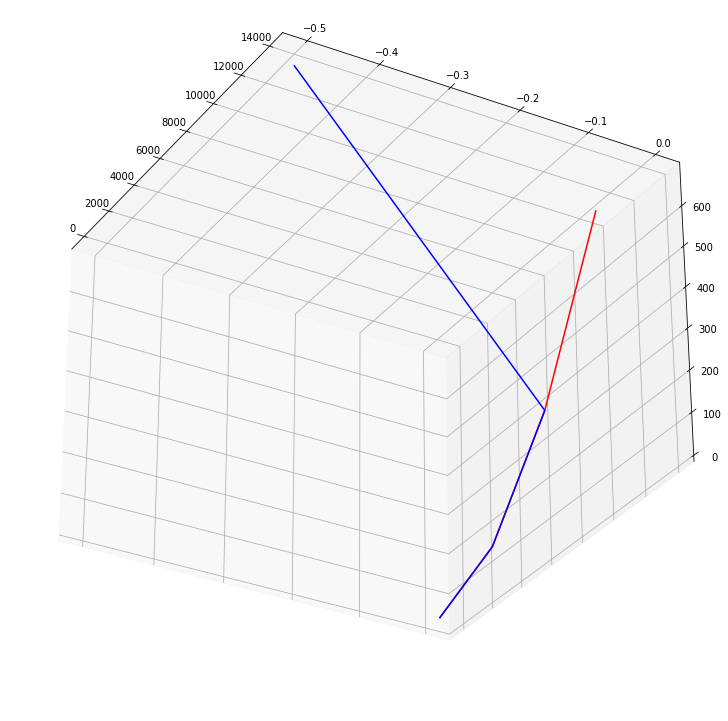

In [193]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [194]:
X,Y,Z

(array([    0.        ,  3684.22828149,  7368.45656297, 13900.43366869]),
 array([ 0.        ,  0.        ,  0.        , -0.49753902]),
 array([  0.        ,  76.13571512, 307.47472797, 685.09205973]))

In [195]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 0.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [196]:
us=fin.T

In [197]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

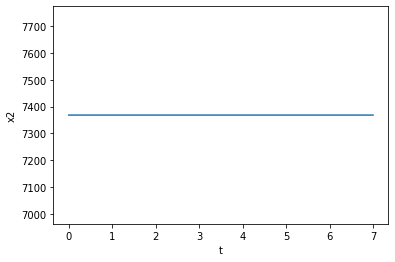

In [198]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

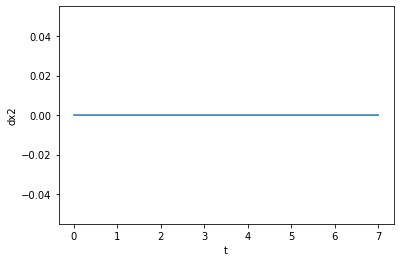

In [199]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

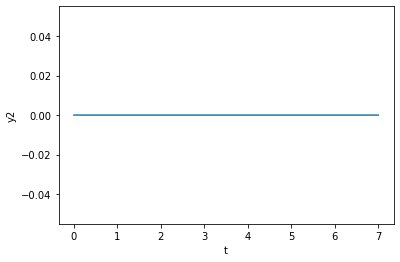

In [200]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

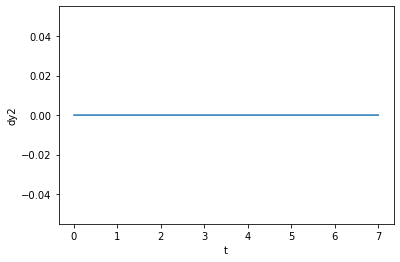

In [201]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

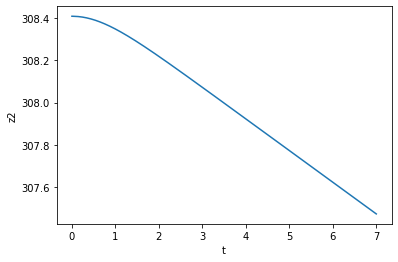

In [202]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

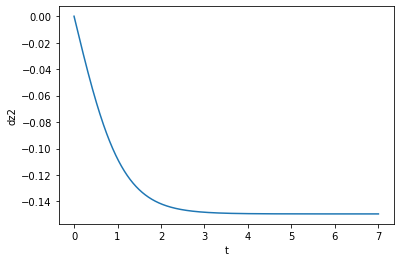

In [203]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

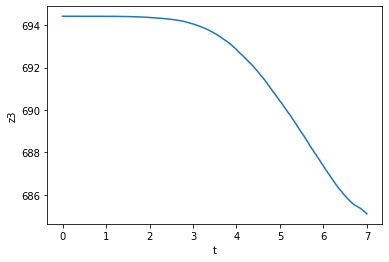

In [204]:
plt.plot(t,us.T[:,19] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

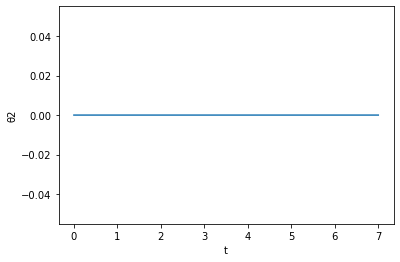

In [205]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

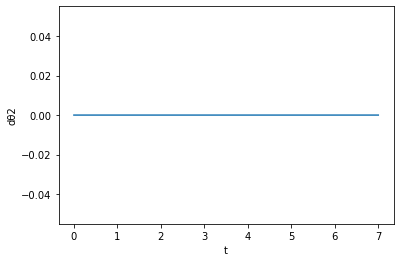

In [206]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

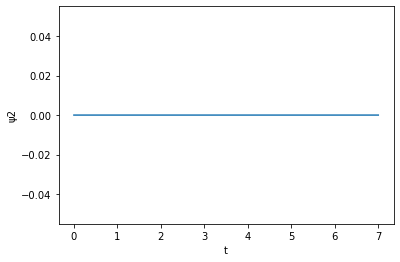

In [207]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

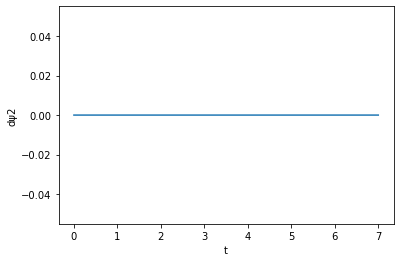

In [208]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()